# Deep Learning Project Report

Authors: 
-   Francesco Vaccari   francesco.vaccari@studenti.unitn.it [239927]
-   Gabriele Stulzer    gabriele.stulzer@studenti.unitn.it  [238778]
-   Nicola Maestri      nicola.maestri@studenti.unitn.it [239920]

### Index
-   [Abstract](#abstract)
-   [Dataset](#dataset)
-   [Baseline](#baseline)
-   [Baseline BLIP + SAM](#baseline-blip-+-sam)
-   [Risclip](#risclip)
    -   [The model](#the-model)
    -   [Locator](#locator)
    -   [Refiner](#refiner)
    -   [Training](#training)
    -   [Evaluation](#evaluation)
-   [Conclusions](#conclusion)
-   [Appendix](#appendix)


***Note about the Code***
\
*In order to make the notebook more fluent, we decided to not insert all the code in this notebook, and to import the model and relatives weights from a folder in Google Drive. In particular the external folder contains: ............................................*



### Abstract

Visual Grounding is a challenging task which aims to locate an object in an image based on a natural language query. Despite impressive advances in computer vision and natural language processing, establishing meaningful connections between distinct elements of images and text to get a good comprehension of context is still a big research area. In our work, we explored some new strategies to solve the problem by laveraging the image-text alignment of Clip as a foundation model for new frameworks specialized in Visual Grounding.

### Introduction

First, we propose a baseline that combines the object detector Yolo [1] and CLIP [2] model without any other component. For each candidate object proposed by Yolo is computed a cosine similarity with the text query and the most similar one is chosen as output prediction. We then tried to break free from the object detector developing a framework based on heatmaps [3] to retrieve the target object and on SAM [4] to draw a proper bounding box. We finally developed a new framework obtained by customizing the CLIP model to compute a low-level probability map from which we find a bounding box through some up-sampling convolutions [5]. Fine-tuning allowed us to exploit Clip strengths without the need for heavy training, therefore beyond the results, it seems to be the most promising direction.

### Related Work

- Visual Grounding
- Reffering Image Segmentation
- Adapters and Fine-tuning

## Dataset

*RefcocogDataset* is our custom dataset class for the RefCOCOg dataset. Most implemented getters are self-explanatory, we just underline the method called *computeGroundTruth*, which uses the mask of the object reffered in the item to compute a low-level binary map with 14x14 resolution. During the locator training it is employed to obtain the groundtruth to compare with the locator output, a 14X14 probability map that locates the target object in the image.

In [ ]:
import json
import pandas
from skimage import io
from torch.utils.data import random_split
from typing import Sequence, Union

from PIL import Image, ImageDraw
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch
import numpy as np


## Official Class used to train and test the model
class RefcocogDataset(Dataset):
    def __init__(self, base_path, split=None, transform=None, tokenization=None):
        annotation_path = base_path + "/annotations/"

        self.IMAGES_PATH = base_path + "/images/"
        self.transform = transform
        self.tokenization = tokenization

        # Load annotations and instances
        tmp_annotations = pandas.read_pickle(annotation_path + "refs(umd).p")
        tmp_instances = json.load(open(annotation_path + "instances.json", "r"))

        # Create dataframes
        annotations_dt = pandas.DataFrame.from_records(tmp_annotations) \
            .filter(items=["image_id", "split", "sentences", "ann_id"])

        instances_dt = pandas.DataFrame.from_records(tmp_instances['annotations'])

        # Add Explode to separate list-like sentences column and use them as separate samples
        # Create a new datapoint with every different phrase for the same image
        self.annotations = annotations_dt \
            .merge(instances_dt[["id", "bbox", "area", "segmentation"]], left_on="ann_id", right_on="id") \
            .explode('sentences', ignore_index=True) \
            .drop(columns="id")

        if split is not None:
            self.annotations = self.__get_annotations_by_split(split.lower())


    def getImage(self, sample):
        # Utility function to get the image from the dataset
        id = sample['idx'][0].item()
        item = self.annotations.iloc[id]
        image = self.__getimage(item.image_id)

        return image


    def getSentences(self, sample):
        # Utility function to get the sentences from the dataset
        id = sample['idx'][0].item()
        item = self.annotations.iloc[id]

        return self.__extract_sentences(item.sentences)


    def __computeGroundTruth(self, item):
        # Utility function to create a mask from the ground truth segmentation        
        image = self.__getimage(item.image_id)
        mask = Image.new("L", image.size)
        draw = ImageDraw.Draw(mask)
        draw.polygon(item.segmentation[0], fill="white", width=0)

        # Resize the computed mask to 640x640 to match the model input
        mask = mask.resize((640, 640))

        return self.__img_preprocess(mask)


    def __bbox_image(self, item, n_px: int = 224):
        # Utility function to create a mask from the ground truth bboxes
        image = self.__getimage(item.image_id)
        mask = Image.new("L", image.size)
        draw = ImageDraw.Draw(mask)
        
        rect_coords = [item.bbox[0], item.bbox[1], item.bbox[0] + item.bbox[2], item.bbox[1] + item.bbox[3]]
        draw.rectangle(rect_coords, fill="white", width=0)

        mask = mask.resize((640, 640))

        resized = T.Resize(n_px, interpolation=Image.BICUBIC)(mask)
        
        crop = T.CenterCrop(n_px)(resized)

        arr = torch.tensor(np.array(crop))

        return self.extract_bbox(arr)


    def extract_bbox(self, out):
        # Extract bbox coordinates from the an mask
        map = out.squeeze(0).squeeze(0).detach().cpu().numpy()
        # normalize map to [0, 1]
        map = (map - map.min()) / (map.max() - map.min())
        # threshold map
        map = (map > 0.8)
        x_min = 225
        y_min = 225
        x_max = 0
        y_max = 0
        for i in range(224):
            for j in range(224):
                if map[i][j] == True:
                    if i < y_min: y_min = i
                    if i > y_max: y_max = i
                    if j < x_min: x_min = j
                    if j > x_max: x_max = j
        
        return x_min, y_min, x_max, y_max
        
    
    def __img_preprocess(self, image: Image, n_px: int = 224, grid_px: int = 14):
        # Utility function to preprocess the input image
        resized = T.Resize(n_px, interpolation=Image.BICUBIC)(image)
        #FIXME: CenterCrop is not working as expected
        crop = T.CenterCrop(n_px)(resized)

        grid = T.Resize(grid_px, interpolation=Image.BICUBIC)(crop)

        arr = torch.tensor(np.asarray(grid))
        arr[arr <= 0.0] = 0 # make the image binary
        arr[arr > 0.0] = 1 # make the image binary
        return arr


    def __computeGroundTruthRefiner(self, item):
        image = self.__getimage(item.image_id)
        mask = Image.new("L", image.size)
        draw = ImageDraw.Draw(mask)
        draw.polygon(item.segmentation[0], fill="white", width=0)

        mask = mask.resize((640, 640))

        return self.__img_preprocess_refiner(mask)


    def __img_preprocess_refiner(self, image: Image, n_px: int = 224):
        resized = T.Resize(n_px, interpolation=Image.BICUBIC)(image)
        #FIXME: CenterCrop is not working as expected
        crop = T.CenterCrop(n_px)(resized)

        arr = torch.tensor(np.asarray(crop))
        arr[arr <= 0.0] = 0 # make the image binary
        arr[arr > 0.0] = 1 # make the image binary
        return arr


    def __get_train_annotations(self):
        return self.annotations[self.annotations.split == "train"].reset_index()

    def __get_annotations_by_split(self, split):
        return self.annotations[self.annotations.split == split].reset_index()

    def __getimage(self, id):
        return Image.open(self.IMAGES_PATH + "COCO_train2014_" + str(id).zfill(12) + ".jpg")

    def __extract_sentences(self, sentence):
        return f"{sentence['sent']}"

    def __tokenize_sents(self, sentences):
        return [self.tokenization(s) for s in sentences]

    def __len__(self):
        return self.annotations.shape[0]

    def __getitem__(self, idx):
        # Return {sample, sentence, id}, bbox
        # Return single sentence, probably preprocess needed so we do not waste data
        
        item = self.annotations.iloc[idx]
        image = self.__getimage(item.image_id).resize((640, 640))
        sentences = self.__extract_sentences(item.sentences)

        if self.transform:
            image = self.transform(image)

        if self.tokenization:
            sentences = self.__tokenize_sents(sentences)

        sample = {'idx': idx, 'image': image, 'sentences': sentences}

        return sample, {'bbox': self.__bbox_image(item), 'gt': self.__computeGroundTruth(item), 'gt_refiner':self.__computeGroundTruthRefiner(item)}
    

## Baseline

In this section, we implemented a baseline using Yolo and CLIP.  We process each image sequentially. Initially, Yolo detects all relevant objects within the image. Then, each candidate object is encoded through the CLIP visual encoder while the text query is processed by the text encoder. Finally, we compute the cosine similarity between the encoded representations of each object and the text query. In case of more than one sentence, we compute the average of similarities for each candidate. We consider as output the object associated with the highest similarity score.

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!gdown 1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq
!tar -xf /content/refcocog.tar.gz
!pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

In [ ]:
import json
import clip
import torch
import pandas
import numpy as np

from torch.utils.data import Dataset, DataLoader
from typing import Sequence, Union

from PIL import Image, ImageDraw


class RefcocogDataset(Dataset):
    def __init__(self, base_path, split=None, transform=None, tokenization=None):
        annotation_path = base_path + "/annotations/"

        self.IMAGES_PATH = base_path + "/images/"
        self.transform = transform
        self.tokenization = tokenization

        tmp_annotations = pandas.read_pickle(annotation_path + "refs(umd).p")
        tmp_instances = json.load(open(annotation_path + "instances.json", "r"))

        annotations_dt = pandas.DataFrame.from_records(tmp_annotations) \
            .filter(items=["image_id", "split", "sentences", "ann_id"])

        instances_dt = pandas.DataFrame.from_records(tmp_instances['annotations'])

        self.annotations = annotations_dt \
            .merge(instances_dt[["id", "bbox", "area"]], left_on="ann_id", right_on="id") \
            .drop(columns="id")

        if split is not None:
            self.annotations = self.__get_annotations_by_split(split.lower())

    def getImage(self, sample):
        id = sample['idx'][0].item()
        item = self.annotations.iloc[id]
        image = self.__getimage(item.image_id)

        return image

    def getSentences(self, sample):
        id = sample['idx'][0].item()
        item = self.annotations.iloc[id]

        return self.__extract_sentences(item.sentences)

    def showImage(self, train_features, train_bbox):
        img = self.getImage(train_features)
        img1 = ImageDraw.Draw(img)
        img1.rectangle([(train_bbox[0].item(), train_bbox[1].item()), (train_bbox[0].item()+train_bbox[2].item(), train_bbox[1].item()+train_bbox[3].item())], outline ="red")
        img.show()

    def __get_annotations_by_split(self, split):
        return self.annotations[self.annotations.split == split].reset_index()

    def __getimage(self, id):
        return Image.open(self.IMAGES_PATH + "COCO_train2014_" + str(id).zfill(12) + ".jpg")

    def __extract_sentences(self, sentences):
        return [f"a photo of {s['sent']}" for s in sentences]

    def __tokenize_sents(self, sentences):
        return [self.tokenization(s) for s in sentences]

    def __len__(self):
        return self.annotations.shape[0]

    def __getitem__(self, idx):
        item = self.annotations.iloc[idx]
        image = self.__getimage(item.image_id)
        sentences = self.__extract_sentences(item.sentences)

        if self.transform:
            image = self.transform(image)

        if self.tokenization:
            sentences = self.__tokenize_sents(sentences)

        sample = {'idx': idx, 'image': image, 'sentences': sentences}

        return sample, item.bbox

In [ ]:
_, preprocess = clip.load("ViT-B/16")
test_dataset = RefcocogDataset("refcocog", split="test", transform=preprocess, tokenization=clip.tokenize)

test_loader = DataLoader(test_dataset, shuffle=False)

100%|████████████████████████████████████████| 335M/335M [00:02<00:00, 128MiB/s]


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
modelYOLO = torch.hub.load('ultralytics/yolov5', 'yolov5x')
modelCLIP, preprocessCLIP = clip.load("ViT-B/16", device=device)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-9-1 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

100%|██████████| 166M/166M [00:01<00:00, 117MB/s]

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
# extract objects from image using YOLO
def YoloBBoxes(img, modelYOLO):
    result = modelYOLO(img)
    bbox = result.pandas().xyxy[0]
    bbox = bbox.reset_index()
    bbox["tconfidence"] = np.nan
    bbox["crop"] = np.nan
    return bbox


# retrieve image crops with coordinates from YOLO
def CropImage(image, boxs):
    crops = []

    for index, row in boxs.iterrows():
        box = (
            row['xmin'],
            row['ymin'],
            row['xmax'],
            row['ymax'],
        )
        crop = image.crop(box)
        crops.append(crop)

        boxs.at[index, 'crop'] = crop

    return crops


# compute similarity between clip embeddings
def computeSimilarity(image, sentences, modelCLIP, preprocessCLIP):
    similarities = []

    for sent in sentences:
        with torch.no_grad():
            image_features = modelCLIP.encode_image(torch.unsqueeze(preprocessCLIP(image).to(device), dim=0)).float().to(device)
            text_features = modelCLIP.encode_text(sent[0].to(device)).float().to(device)

        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        similarities.append(text_features.cpu().numpy() @ image_features.cpu().numpy().T)

    return sum(similarities)/len(similarities)


# needed for IoU computation
def computeIntersection(fx1, fy1, fx2, fy2, sx1, sy1, sx2, sy2):
    dx = min(fx2, sx2) - max(fx1, sx1)
    dy = min(fy2, sy2) - max(fy1, sy1)
    if (dx>=0) and (dy>=0):
        area = dx*dy
    else:
        area = 0
    return area


# accuracy is IoU between two bboxes
def computeAccuracy(bboxes, index, label):
    x_min, y_min, x_max, y_max = bboxes['xmin'][index], bboxes['ymin'][index], bboxes['xmax'][index], bboxes['ymax'][index]
    x, y, w, h = label[0].item(), label[1].item(), label[2].item(), label[3].item()

    intersection = computeIntersection(x_min, y_min, x_max, y_max, x, y, x+w, y+h)

    area1 = (x_max - x_min) * (y_max - y_min)
    area2 = w * h

    return intersection / (area1 + area2 - intersection)

In [ ]:
def baseline(loader, dataset, modelYOLO, modelCLIP, preprocessCLIP):
    n_samples = 0
    tot_accuracy = 0

    for data_features, data_bbox in loader:

        bboxes = YoloBBoxes(dataset.getImage(data_features), modelYOLO) # extract bboxes from image using YOLO
        crops = CropImage(dataset.getImage(data_features), bboxes) # retrieve crops for each object

        # determine which crop/object has highest similarity
        # crop with highest similarity is the predicted object
        # compute IoU between predicted object and ground truth
        if len(crops) > 0:
            highest_similarity = 0
            index_pred = 0

            for i, crop in enumerate(crops):
                similarity = computeSimilarity(crop, data_features['sentences'], modelCLIP, preprocessCLIP)

                if similarity > highest_similarity:
                    highest_similarity = similarity
                    index_pred = i

            accuracy = computeAccuracy(bboxes, index_pred, data_bbox)
        else:
            accuracy = 0

        tot_accuracy += accuracy
        n_samples += 1
        print(f'Image {n_samples:^6}/{len(dataset):^6}\t{accuracy:.4f}')

    return tot_accuracy/n_samples

In [ ]:
print(f'Mean accuracy IoU: {baseline(test_loader, test_dataset, modelYOLO, modelCLIP, preprocessCLIP):.8f}')

Output streaming troncato alle ultime 5000 righe.
Image   25  / 5023 	0.1521
Image   26  / 5023 	0.1293
Image   27  / 5023 	0.0445
Image   28  / 5023 	0.9481
Image   29  / 5023 	0.9482
Image   30  / 5023 	0.9250
Image   31  / 5023 	0.0000
Image   32  / 5023 	0.9158
Image   33  / 5023 	0.9558
Image   34  / 5023 	0.0993
Image   35  / 5023 	0.0000
Image   36  / 5023 	0.9663
Image   37  / 5023 	0.9669
Image   38  / 5023 	0.8715
Image   39  / 5023 	0.2205
Image   40  / 5023 	0.8821
Image   41  / 5023 	0.0220
Image   42  / 5023 	0.0000
Image   43  / 5023 	0.9309
Image   44  / 5023 	0.9230
Image   45  / 5023 	0.9748
Image   46  / 5023 	0.8104
Image   47  / 5023 	0.8614
Image   48  / 5023 	0.8428
Image   49  / 5023 	0.0000
Image   50  / 5023 	0.9546
Image   51  / 5023 	0.9390
Image   52  / 5023 	0.9667
Image   53  / 5023 	0.2037
Image   54  / 5023 	0.1862
Image   55  / 5023 	0.0243
Image   56  / 5023 	0.9638
Image   57  / 5023 	0.9649
Image   58  / 5023 	0.0000
Image   59  / 5023 	0.8970
Image

### Observations

This baseline adaptes CLIP for Visual Grounding by simply incorporating the model as part of a longer pipeline.
Accuracy evaluation is measured through Intersection over Union (IoU), the final result is the mean IoU.

Our baseline reached an accuracy of $57.997\%$, which highlights the remarkable zero-shot capabilities of CLIP. This outcome is due to the ability of Yolo to extract a wide range of candidates and of Clip to compute affinity between image and text.\
However, we found also important limitations that need to be tackled to improve the system:

1. Dependency on the object detector performance\
The system relies heavily on the object detector's performance.
If the object detector does not retrieve an object, there is no possibility to output the correct bbox and this is often the case if we are looking for small objects partially occluded.

2. Lack of Context Comprehension\
In presence of multiple instances of the same object, this baseline is not capable of using the context to infer which is the correct one. This is a major problem because relating text and image components is at the heart of Visual Grounding, therefore it puts in evidence the necessity for further modifications.


We moved on trying to face these two issues. At first, we developed another pipeline in which there is no need for an object detector and subsequently, we focused on the problem of the context which forced us to embark on a new path.

## Baseline BLIP + SAM

This baseline presents an alternative pipeline that removes the necessity for an object detector. 
\
We employ the Lavis library to extract from each image a set of heat maps based on the text instances.
These are then used to identify some points with high confidence to belong to the target object.
Finally, we utilize SAM, Segment Anything Model, to obtain a mask of the whole object and the corresponding bounding box to return as output.

*Note:
\
The code presented below will provide more details about the implemantation, however we want to underline that we only scratched this idea with a basic pipeline. The proposed solution is naive and the system isn't really able to comprehend the relationship between text and image.
Moreover, we used BLIP, instead of CLIP, to get a first overview of the pipeline and we decided to show this version, even if we developed one adapted to CLIP ViT-B/16. Nevertheless it manages to achieve an acceptable accuracy without using Yolo, which was our first goal. We will try to move a step further in this direction with the model presented in the next section, although we decided to follow another approach.*


**Example**

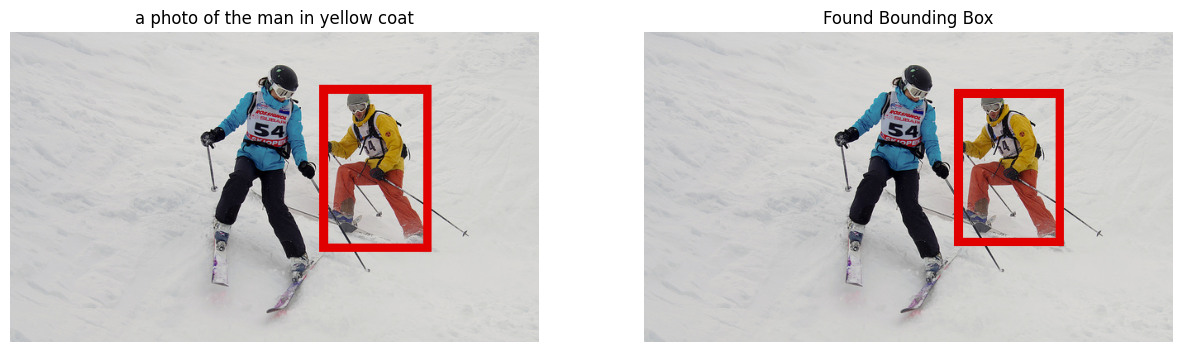

*Step 1: heatmap extraction based on the text query*

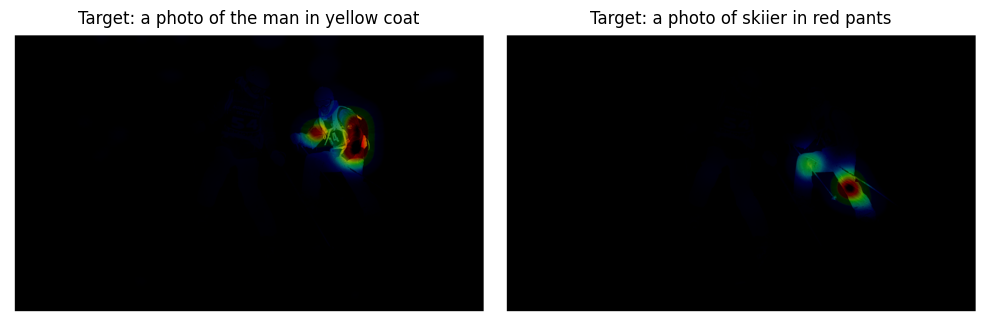

*Step 2: Bounding Box extraction based on SAM*

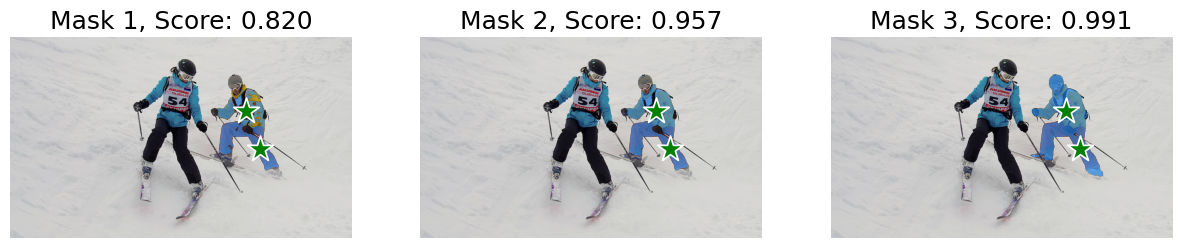

***BLIP: Boostraping Language Image Pretraining***

BLIP is a VLP framework capable of visual-language understanding and caption generation. The model was presented in the lectures and further documentation is pointed here [3]. In this baseline, it is used to retrieve an heat map based on the image and the sentence. Then, we simply apply a treshold to extract a unique stain and performe an average to get the position of the center.

***SAM: Segment Anything Model***

Segment Anything Model (SAM) is an innovative deep learning model recently released by Meta. It is specialized in Segmentation and its capacity to obtain masks with different granularities is impressive. It can be employed for a wide range of tasks, in our case it is used to capture the whole object just passing to the model some of its points. Code and other details can be found on the official website, on Github and in the paper [3].

In [ ]:
import torch

device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'

### Blip

In [ ]:
# LAVIS
!pip install salesforce-lavis

import lavis
from lavis.common.gradcam import getAttMap
from lavis.models.blip_models.blip_image_text_matching import compute_gradcam
import locale

# from typing import Sequence, Union
locale.getpreferredencoding = lambda: 'UTF-8'

# Instantiate the blip model
blip_im_text_match, image_preprocess_im_text_match, text_preprocess_im_text_match = lavis.models.load_model_and_preprocess(
    name="blip_image_text_matching", model_type="large", is_eval=True, device=device
  )

### SAM

In [ ]:
#SAM
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

from segment_anything import sam_model_registry, SamPredictor

sys.path.append("..")
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

# Instantiate SAM model
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)


### Dataset

In [ ]:
# CLIP
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

import clip

#Instantiate Clip
modelCLIP, preprocessCLIP = clip.load("ViT-B/16", device=device)
modelCLIP.eval()

In [ ]:
from torch.utils.data import Dataset, DataLoader
import json
import torch
import torch.nn.functional as F
import numpy as np
import pandas
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt


class RefcocogDataset(Dataset):
    def __init__(self, base_path, split=None, transform=None, tokenization=None):
        annotation_path = base_path + "/annotations/"

        self.IMAGES_PATH = base_path + "/images/"
        self.transform = transform
        self.tokenization = tokenization

        tmp_annotations = pandas.read_pickle(annotation_path + "refs(umd).p")
        tmp_instances = json.load(open(annotation_path + "instances.json", "r"))

        annotations_dt = pandas.DataFrame.from_records(tmp_annotations) \
            .filter(items=["image_id", "split", "sentences", "ann_id"])

        instances_dt = pandas.DataFrame.from_records(tmp_instances['annotations'])

        self.annotations = annotations_dt \
            .merge(instances_dt[["id", "bbox", "area"]], left_on="ann_id", right_on="id") \
            .drop(columns="id")

        if split is not None:
            self.annotations = self.__get_annotations_by_split(split.lower())

    def getImage(self, sample):
        id = sample['idx'][0].item()
        item = self.annotations.iloc[id]
        image = self.__getimage(item.image_id)

        return image

    def getSentences(self, sample):
        id = sample['idx'][0].item()
        item = self.annotations.iloc[id]

        return self.__extract_sentences(item.sentences)

    def showImage(self, train_features, train_bbox):
        img = self.getImage(train_features)
        img1 = ImageDraw.Draw(img)
        img1.rectangle([(train_bbox[0].item(), train_bbox[1].item()), (train_bbox[2].item(), train_bbox[3].item())], outline ="red")
        img.show()

    def __get_annotations_by_split(self, split):
        return self.annotations[self.annotations.split == split].reset_index()

    def __getimage(self, id):
        return Image.open(self.IMAGES_PATH + "COCO_train2014_" + str(id).zfill(12) + ".jpg")

    def __extract_sentences(self, sentences):
        return [f"a photo of {s['sent']}" for s in sentences]

    def __tokenize_sents(self, sentences):
        return [self.tokenization(s) for s in sentences]

    def __len__(self):
        return self.annotations.shape[0]

    def __getitem__(self, idx):
        item = self.annotations.iloc[idx]
        image = self.__getimage(item.image_id)
        sentences = self.__extract_sentences(item.sentences)

        if self.transform:
            image = self.transform(image)

        if self.tokenization:
            sentences = self.__tokenize_sents(sentences)

        sample = {'idx': idx, 'image': image, 'sentences': sentences}

        return sample, item.bbox

In [ ]:
# Instantiation of Dataset and Dataloader

REFCOCOG_PATH = "refcocog"

train_dataset = RefcocogDataset(REFCOCOG_PATH, split="train", transform=preprocessCLIP, tokenization=clip.tokenize)
val_dataset = RefcocogDataset(REFCOCOG_PATH, split="val", transform=preprocessCLIP, tokenization=clip.tokenize)
test_dataset = RefcocogDataset(REFCOCOG_PATH, split="test", transform=preprocessCLIP, tokenization=clip.tokenize)

train_dataloader = DataLoader(train_dataset, shuffle=False)
val_dataloader = DataLoader(val_dataset, shuffle=False)
test_dataloader = DataLoader(test_dataset, shuffle=False)

### Functions

In [ ]:
def cosine_similarity(images_z: torch.Tensor, texts_z: torch.Tensor):
    """ Compute cosine similarity between image and text  """
    # normalization and computation
    images_z /= images_z.norm(dim=-1, keepdim=True)
    texts_z /= texts_z.norm(dim=-1, keepdim=True)
    similarity = (texts_z @ images_z.T)

    return similarity.cpu()

def center_da_gradcam(gradcam, image: Image, text_tokens: torch.Tensor = None, for_visualization=False):
    """ Compute heatmap given an image and a text query and retrieve from it a central point """
    # get color map
    image_norm = np.float32(image) / 255
    center = [0, 0]
    gradcam = getAttMap(image_norm, gradcam[0][1], blur=True)
    colour_map = gradcam - image_norm

    xs = []
    ys = []

    # if for_visualization is True: return a point, the heat map and the thresholded heat map
    # the point is the center of the bounding box of the thresholded heat map
    if for_visualization:
      h, w, c = colour_map.shape
      red_channel = np.zeros((h, w, 1))
      # thresholding
      for i in range(colour_map.shape[0]):
        for j in range(colour_map.shape[1]):
          # the tuning of the parameters was done empirically
          if (colour_map[i][j][0] > 0.2 and colour_map[i][j][1] < 0.2 and colour_map[i][j][2] < 0.2):
            red_channel[i][j][0] = 1
            xs.append(i)
            ys.append(j)
      # The center of the image is in the middle of the bounding box of the thresholded heat map
      if len(xs)!=0:
        center[0] = int((max(xs)+min(xs))/2)
        center[1] = int((max(ys)+min(ys))/2)
      return center, colour_map, red_channel

    # if for_visualization is False: return only the center of the bounding box of the thresholded heat map
    else:
      for i in range(colour_map.shape[0]):
        for j in range(colour_map.shape[1]):
          if (colour_map[i][j][0] > 0.2 and colour_map[i][j][1] < 0.2 and colour_map[i][j][2] < 0.2):
            xs.append(i)
            ys.append(j)
      if len(xs)!=0:
        center[0] = int((max(xs)+min(xs))/2)
        center[1] = int((max(ys)+min(ys))/2)
      return center


# --------------------------------
# Functions for computing Accuracy
# --------------------------------
      
def computeIntersection(bbox, BBOX):
    """ Compute the intersection of two bounding boxes  """
    x_min = bbox[0]
    y_min = bbox[1]
    x_max = bbox[2]
    y_max = bbox[3]
    X_MIN = BBOX[0]
    Y_MIN = BBOX[1]
    X_MAX = BBOX[2]
    Y_MAX = BBOX[3]

    dx = min(x_max, X_MAX) - max(x_min, X_MIN)
    dy = min(y_max, Y_MAX) - max(y_min, Y_MIN)
    if (dx>=0) and (dy>=0):
        area = dx*dy
    else:
        area = 0
    return area

def computeAccuracy(bbox, BBOX):
    """ Compute the intersection of union of two bounding box """
    intersection = computeIntersection(bbox, BBOX)
    area1 = (bbox[2]-bbox[0])*(bbox[3]-bbox[1])
    area2 = (BBOX[2]-BBOX[0])*(BBOX[3]-BBOX[1])
    union = area1 + area2 - intersection
    return intersection / union

# ------------------------------
# Functions for visualization
# ------------------------------

def print_bbox(image, t_bbox, f_bbox, title):
    """ Plot image with target bbox and image with the found bbox """
    image_target_bbox = image.copy()
    for i in range(t_bbox[0], t_bbox[2]):
      for j in range(t_bbox[1], t_bbox[3]):
        if (t_bbox[0]<=i and i<=t_bbox[0]+10) or (t_bbox[1]<=j and j<=t_bbox[1]+10) or (t_bbox[2]-10<=i and i<=t_bbox[2]) or (t_bbox[3]-10<=j and j<=t_bbox[3]):
          image_target_bbox.putpixel((j, i), (225, 0, 0))

    image_found_bbox = image.copy()
    for i in range(f_bbox[0], f_bbox[2]):
      for j in range(f_bbox[1], f_bbox[3]):
        if (f_bbox[0]<=i and i<=f_bbox[0]+10) or (f_bbox[1]<=j and j<=f_bbox[1]+10) or (f_bbox[2]-10<=i and i<=f_bbox[2]) or (f_bbox[3]-10<=j and j<=f_bbox[3]):
          image_found_bbox.putpixel((j, i), (225, 0, 0))

    plt.figure(figsize=(15,8))
    # target bbox
    plt.subplot(1,2,1)
    plt.imshow(image_target_bbox)
    plt.title(title)
    plt.axis('off')
    # found bbox
    plt.subplot(1,2,2)
    plt.imshow(image_found_bbox)
    plt.title('Found Bounding Box')
    plt.axis('off')

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

### Baseline and Visualization function

In [ ]:
def check_baseline(loader, dataset, visualize_colormaps = False, n_sample_to_check = 1):
  """ Visualize what the system does with a specific sample"""

  n_samples = 0

  for data_features, data_bbox in loader:

    if n_samples in range(0, n_sample_to_check-1):
      n_samples += 1
      continue

    # Problems with this specific samples
    if (n_samples in range(520,530)) or (n_samples in range(750, 770)) or (n_samples in range(2750, 2760)) or (n_samples in range(2945, 2950)):
      n_samples += 1
      continue

    # Get text queries and target bounding
    sentences = dataset.getSentences(data_features)
    target_bbox = [0, 0, 0, 0]
    target_bbox[0] = int(data_bbox[1].item())
    target_bbox[1] = int(data_bbox[0].item())
    target_bbox[2] = int(data_bbox[1].item() + data_bbox[3].item())
    target_bbox[3] = int(data_bbox[2].item() + data_bbox[0].item())

    # Get image and pass it to SAM predictor
    image = dataset.getImage(data_features)
    img = np.array(image)
    predictor.set_image(img)

    points = []
    color_maps = []
    red_channels = []
    for target in sentences:
      input_text = text_preprocess_im_text_match["eval"](target)
      input_image = image_preprocess_im_text_match["eval"](image).unsqueeze(0).cuda()
      text_tokens = blip_im_text_match.tokenizer(input_text, return_tensors="pt").to('cuda')
      gradcam, _ = compute_gradcam(
          blip_im_text_match, input_image, input_text, text_tokens, block_num=7
        )
      point, color_map, red_channel = center_da_gradcam(gradcam, image, text_tokens=text_tokens, for_visualization=True)
      color_maps.append(color_map)
      red_channels.append(red_channel)
      point = [point[1], point[0]]
      points.append(point)

    input_point = np.array(points)
    input_label = np.ones(len(sentences))

    masks, scores, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )


    xs = []
    ys = []
    for i in range(masks.shape[1]):
      for j in range(masks.shape[2]):
        if masks[0][i][j]*1+masks[1][i][j]*1+masks[2][i][j]*1>0:
          xs.append(i)
          ys.append(j)

    found_bbox = [min(xs), min(ys), max(xs), max(ys)]

    # Show image and target bbox
    print_bbox(image, target_bbox, found_bbox, sentences[0])

    # Plot SAM masks
    plt.figure(figsize=(15,8))
    for i, (mask, score) in enumerate(zip(masks, scores)):
      if i <= 2:
        plt.subplot(1,3,i+1)
        plt.imshow(image)
        show_mask(mask, plt.gca())
        show_points(input_point, input_label, plt.gca())
        plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')

    # Plot Heat Map
    if visualize_colormaps:
      num_heatmaps = min(len(sentences), 3)
      plt.figure(figsize=(15,8))
      for i in range(num_heatmaps):
        plt.subplot(1,3,i+1)
        plt.imshow(color_maps[i])
        plt.title(sentences[i])
        plt.axis('off')

      plt.figure(figsize=(15,8))
      for i in range(num_heatmaps):
        plt.subplot(1,3,i+1)
        plt.imshow(red_channels[i])
        plt.axis('off')

    # Compute Accuracy
    accuracy = computeAccuracy(found_bbox, target_bbox)
    correct = False
    if accuracy >= 0.5:
      correct = True

    print('------------------------------------------------------------------------------')
    print('Correctly Classified:', correct, '\tAccuracy:', round(accuracy, 2))
    print('------------------------------------------------------------------------------')

    break

  return

In [ ]:
def baseline(loader, dataset):
  """ Baseline without Object Detector"""

  n_samples = 1
  tot_accuracy = 0
  tot_correct = 0
  s = 0

  for data_features, data_bbox in loader:

    # Problems with this specific samples
    if (n_samples in range(520,530)) or (n_samples in range(750, 770)) or (n_samples in range(2750, 2760)) or (n_samples in range(2945, 2950)):
      n_samples += 1
      s += 1
      continue

    # Get text queries and target bounding
    sentences = dataset.getSentences(data_features)
    target_bbox = [0, 0, 0, 0]
    target_bbox[0] = int(data_bbox[1].item())
    target_bbox[1] = int(data_bbox[0].item())
    target_bbox[2] = int(data_bbox[1].item() + data_bbox[3].item())
    target_bbox[3] = int(data_bbox[2].item() + data_bbox[0].item())

    # Get image and pass it to SAM predictor
    image = dataset.getImage(data_features)
    img = np.array(image)
    predictor.set_image(img)

    points = []
    for target in sentences:
      input_text = text_preprocess_im_text_match["eval"](target)
      input_image = image_preprocess_im_text_match["eval"](image).unsqueeze(0).cuda()
      text_tokens = blip_im_text_match.tokenizer(input_text, return_tensors="pt").to('cuda')
      gradcam, _ = compute_gradcam(
          blip_im_text_match, input_image, input_text, text_tokens, block_num=7
        )
      point = center_da_gradcam(gradcam, image, text_tokens=text_tokens)
      point = [point[1], point[0]]
      points.append(point)

    input_point = np.array(points)
    input_label = np.ones(len(sentences))

    masks, _, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )

    xs = []
    ys = []
    for i in range(masks.shape[1]):
      for j in range(masks.shape[2]):
        if masks[0][i][j]*1+masks[1][i][j]*1+masks[2][i][j]*1>0:
          xs.append(i)
          ys.append(j)

    found_bbox = [min(xs), min(ys), max(xs), max(ys)]

    # Compute Accuracy
    accuracy = computeAccuracy(found_bbox, target_bbox)
    tot_accuracy += accuracy
    if accuracy>=0.5:
      tot_correct += 1

    if n_samples%100==0:
      print('TOT_Correctly Classified:', tot_correct, '/', (n_samples-s), '\tTOT_Accuracy:', round(tot_accuracy/(n_samples-s),2))
      print('-----------------------------------------------------------------')

    n_samples += 1

  return tot_correct/n_samples


### Try 

------------------------------------------------------------------------------
Correctly Classified: True 	Accuracy: 0.92
------------------------------------------------------------------------------


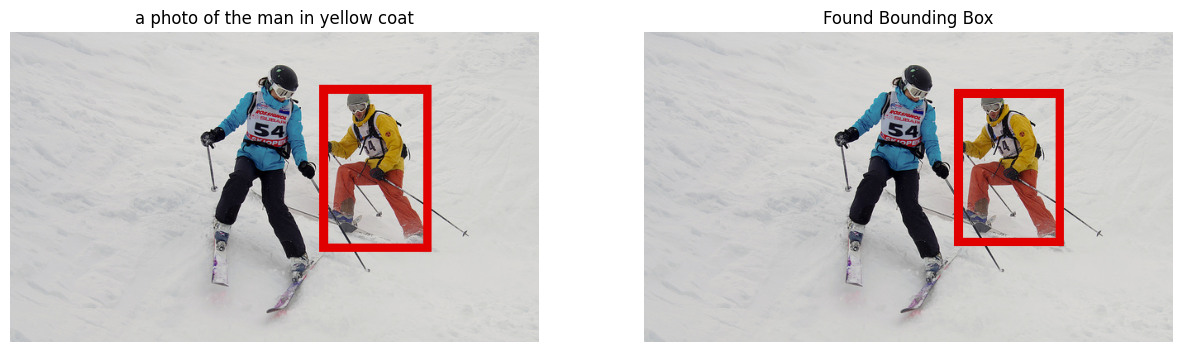

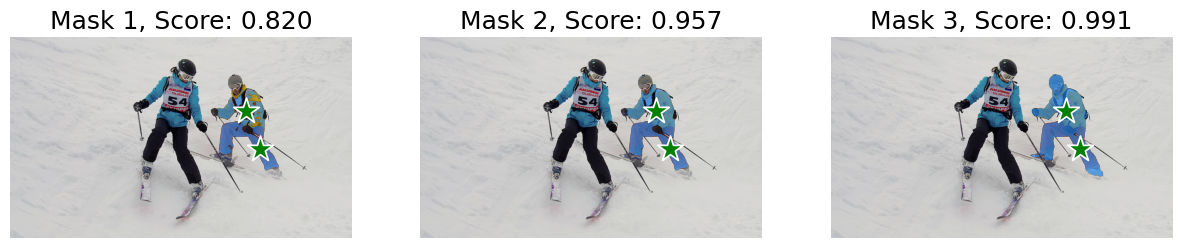

In [ ]:
# Set a sample to visualize

# Set the index of the sample to visualize
sample_index = 1
# Set to True to visualize the heatmaps
vis_heat_map = False

check_baseline(test_dataloader, test_dataset, visualize_colormaps=vis_heat_map, n_sample_to_check=sample_index)

In [ ]:
# To verify the accuracy of this baseline uncomment this line of code

# baseline(test_dataloader, test_dataset)

### Observations

This baseline proves that it is not strictly necessary to use an object detector to perform Visual Grounding.
From the visual encoder, we can retrieve how much each pixel contributes to the similarity with the text query and use this to extract information about the relevant objects in the scene.
\
The measured accuracy is 44% mean IoU.
\
A little of engineering pushed the performance up by 3%, showing there is a wide range for improvements. In particular, we add a preprocess of the image before to extract the heat maps. The original image is subdiveded in many fragments and for each text query a sigle heat map is computed on the fragment which has higher similarity with the specific sentence.
\
Nevertheless, a big limitation of this baseline is that the heat maps put in evidence pixels activated by the text without particular distinction between the subject and the context. We think a specific network able to better relate the heatmaps with the text query could overcome this issue and achieve better performance, however, we will propose an alernative approach in the last section.

## RISCLIP

In [5] the authors propose an interesting approach that adapts CLIP for the task of Referring Image Segmentation (RIS). The authors add in the model of CLIP Fusion and Backbone Adapters to improve RIS capablities, doing so allows to only train the block introduced while keeping the original CLIP framework frozen. This allows to exploit the rich and general image-text alignment that CLIP offers and is not as computationally expesinve as performing a full fine-tuning of the model. The Fusion adapters have the objective of allowing multi-modal communication between the visual and textual layers of transformers, while the Backbone Adapters inject new knowledge for solving the task at hand.

In our project we replicated the structure of the model described in the paper [5] for the ViT-B/16 version of CLIP and adapted it to the task of Visual Grounding.

### The Model

The model consists of two main parts: Locator and Refiner. The Locator is the CLIP model with the addition of the Adapters and a minor changes to produce a different output than the standard implementation. The Locator takes as input the image already patchified and outputs a probability map with the same shape of the input. Then the Refiner, consisting of a series of up-sampling operations, turns the the probability map into a pixel-level probability map from which the final bounding box is extracted.

The probability map is obtained by computing the cosine similarity between the textual representation of the query and the visual representation of each patch. This differs from the standard CLIP model where the image was encoded into a single token summarizing the content of the image. In our particular case, with the ViT-B/16 version of CLIP being used, the probability map will contain a grid of 14x14 values of similarity which tell us where in the image the object referred by the query is most likely located. The Refiner then performs the up-sampling givin as output an higher resolution probability map.

The figure below shows the structure of the model.

<p align="center">
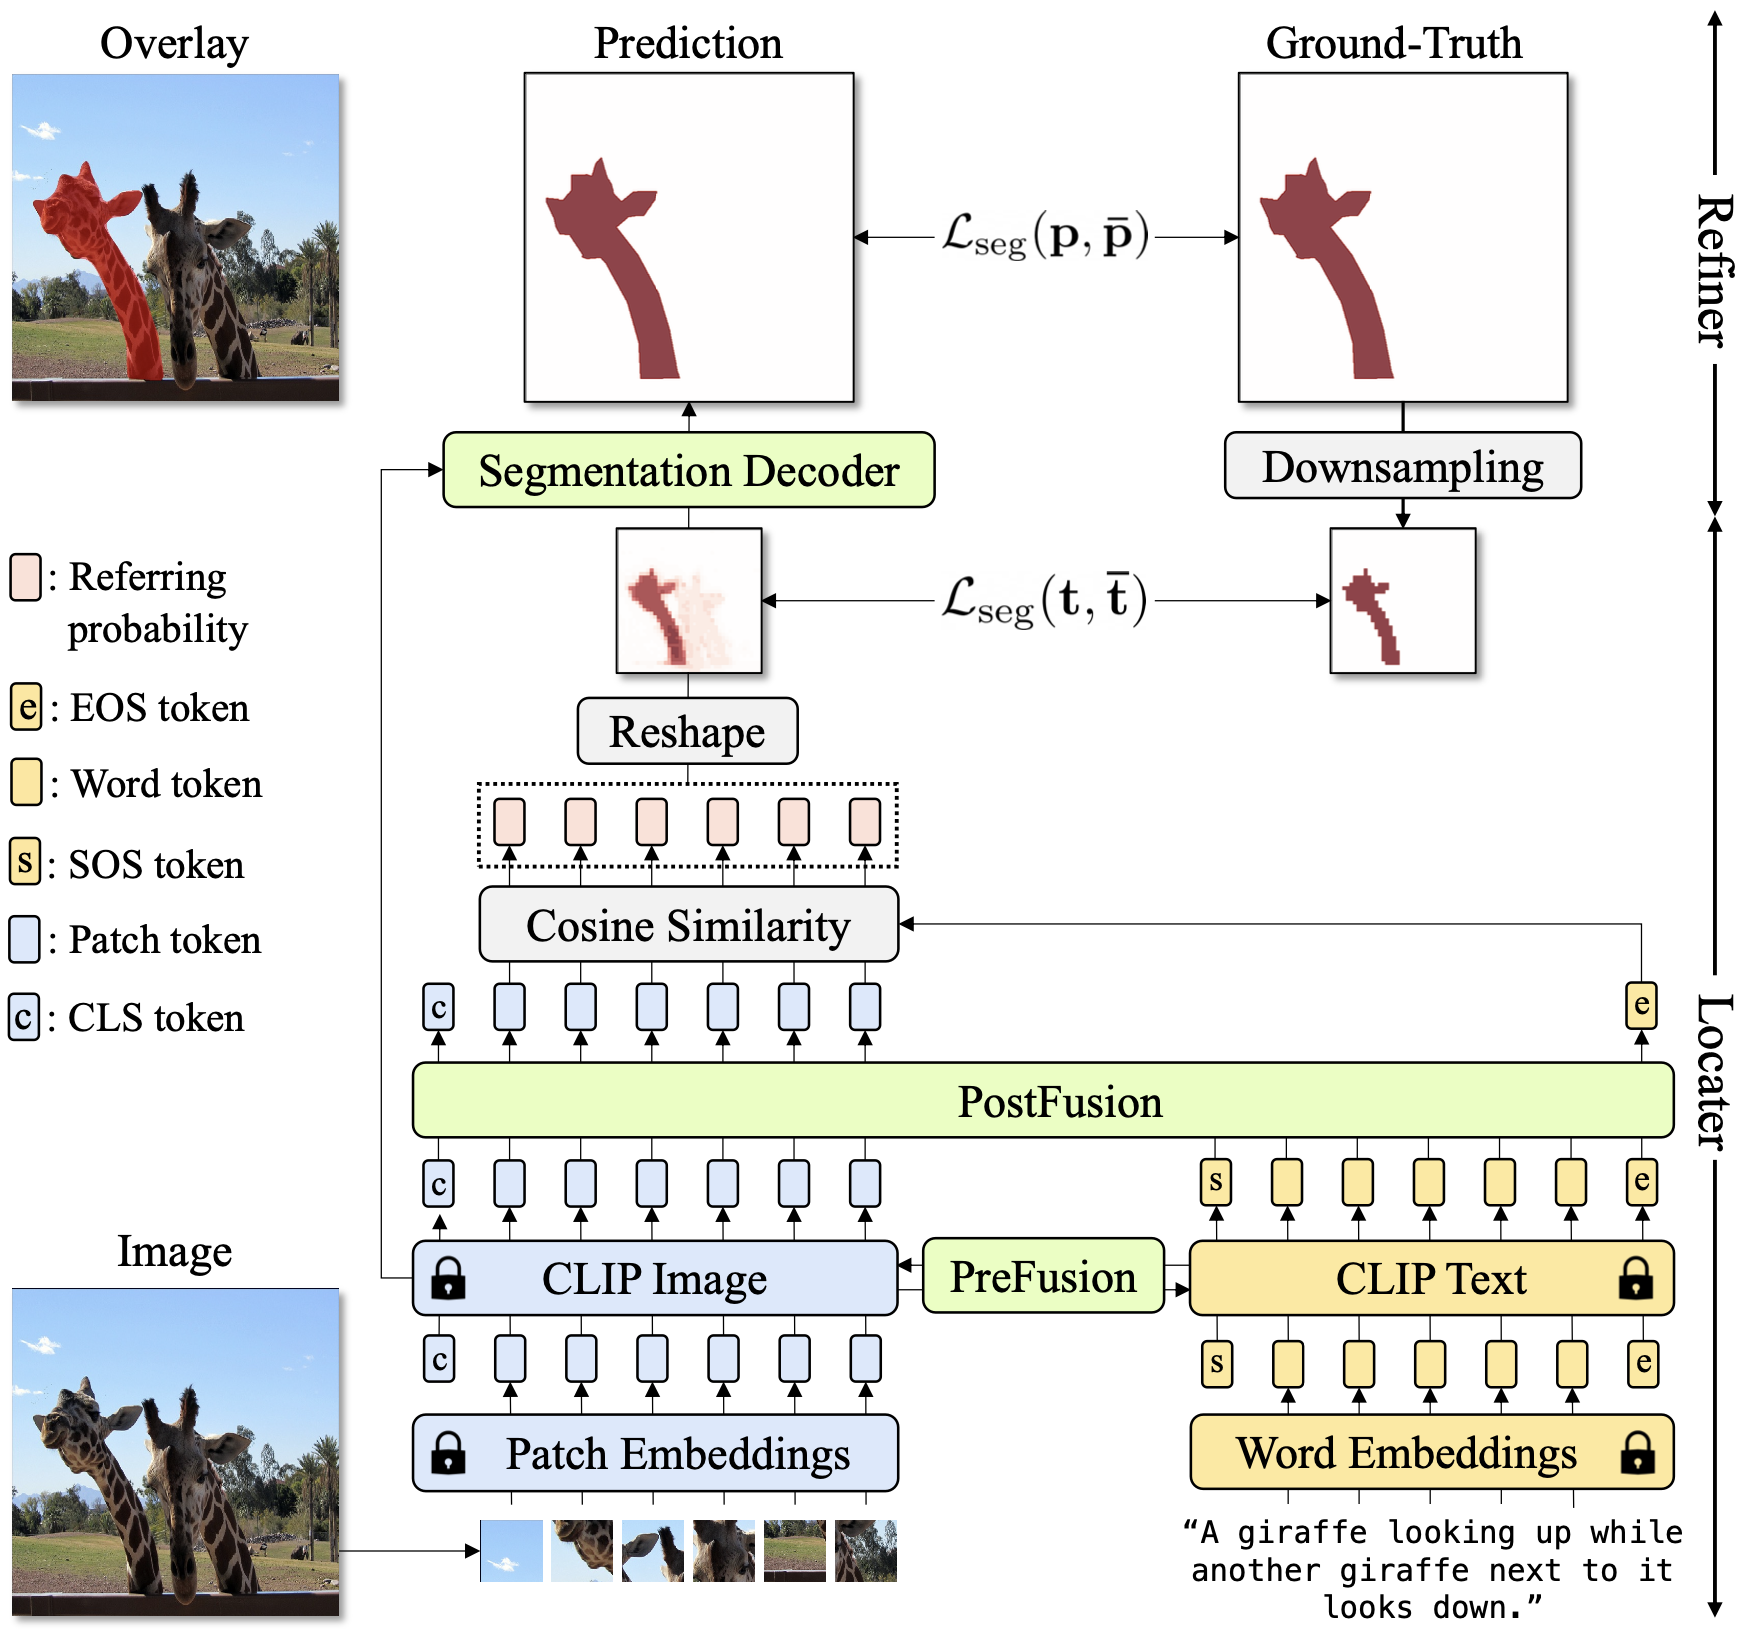
</p>

### Locator

We can identify three main components in the Locator network: CLIP backbone, Backbone Adapters and Fusion Adapters. The CLIP backbone is simply a CLIP model on top o which adapters are added to fine tune for the specific task. For the purpose of explaining where the adapters are added, let us remind the CLIP architecture. CLIP consists of two main channels, image encoder and text encoder, which are both composed of multiple consecutive layers of transformer blocks, 12 for each encoder in the specific version we used. Each transformer block can be divided into two submodules: multi-head self-attention (MHSA) and multi-layer perceptron (MLP), each preceded by a normalization layer (LN). The forward pass for the $i_{th}$ block is as follows:

$$
\bar{f}_{i} = \text{MHSA}(\text{LN}(f_{i-1})) + f_{i-1}
$$
$$
f_{i} = \text{MLP}(\text{LN}(\bar{f}_{i})) + \bar{f}_i
$$

Where $f_{i-1}$ is the output of the previous block and $f_{i}$ will be the input for the next block.

#### Backbone Adapters

The Backbone Adapters are added to the CLIP backbone to improve the model capabilities for our task. They consists of a down-projection linear layer, a non-linear activation, and an up-projection linear layer to the original dimension. This structure is added in a residual way both after the MHSA and the MLP submodules of each transformer block that compose either the visual or textual encoders. With $\text{AD}_{\text{MHSA}}$ representing the adapter added after the MHSA submodule and $\text{AD}_{\text{MLP}}$ the adapter added after the MLP submodule, the forward pass for the $i_{th}$ transformer block is as follows:

$$
\bar{f}_{i} = \text{AD}_{\text{MHSA}}(\text{MHSA}(\text{LN}(f_{i-1})) + f_{i-1}) + \text{MHSA}(\text{LN}(f_{i-1})) + f_{i-1}
$$
$$
f_{i} = \text{AD}_{\text{MLP}}(\text{MLP}(\text{LN}(\bar{f}_{i})) + \bar{f}_i) + \text{MLP}(\text{LN}(\bar{f}_{i})) + \bar{f}_i
$$

#### Fusion Adapters

Fusion Adapters allow text and image features to communicate and fuse the cross-model information coming from the two encoders. This cross-modal fusion can be performed both during the encoding phase, between same level layers of transformer blocks, or can be performed once the encoding is completed, between the outputs of last layer. For the first case, we will refer to the fusion adapters as PreFusion Adapters, in the second case as PostFusion Adapters. Much like for the Backbone Adapters, the output of the fusion adapters is added in a residual way to the original features.

For both PreFusion and PostFusion Adapters a linear normalization layer is applied before every shared space projection, cross-attention, multi-head self-attention or multi-layer perceptron module. For simplicity we will not report these layers in the equations.

##### PreFusion Adapters

The PreFusion Adapters let two transformer blocks, one from each encoder at layer $i$, communicate. Since a single adapter receives as input features coming from both modalities, first a linear projection to a shared dimension is applied ($W_{v2s}$ and $W_{t2s}$), then two separate cross-attention modules proced visual and textual multi-modal features (MHA), that are lastly projected back to the original dimension ($W_{s2v}$ and $W_{s2t}$). In the cross-attention module, to produce for example the multi-modal features that will be given back to the visual encoder, we set the original image features as the query, while the text features are used as key and value; the opposite happens for the textual encoder. The computation to obtain the cross-modal image features for the $i_{th}$ layer is as follows:

$$
s^{v}_{i} = W_{v2s}f^{v}_{i} , \quad s^{t}_{i} = W_{t2s}f^{t}_{i}
$$
$$
q^{v} = W_{q}s^{v}_{i} , \quad k^{t} = W_{k}s^{t}_{i} , \quad v^{t} = W_{v}s^{t}_{i}
$$
$$
m^{v}_{i} = \text{MHA}(q^{v} , k^{t}, v^{t})
$$
$$
\bar{f}^{v}_{i} = W_{s2v}m^{v}_{i}
$$

The same computation but with roles reversed is performed to obtain the cross-modal textual features. The outputs are then added to the original features in a residual way for both modalities:

$$
f^{v}_{i} = f^{v}_{i} + \bar{f}^{v}_{i}
$$
$$
f^{t}_{i} = f^{t}_{i} + \bar{f}^{t}_{i}
$$

The figure below shows the PreFusion Adapters structure.

<p align="center">
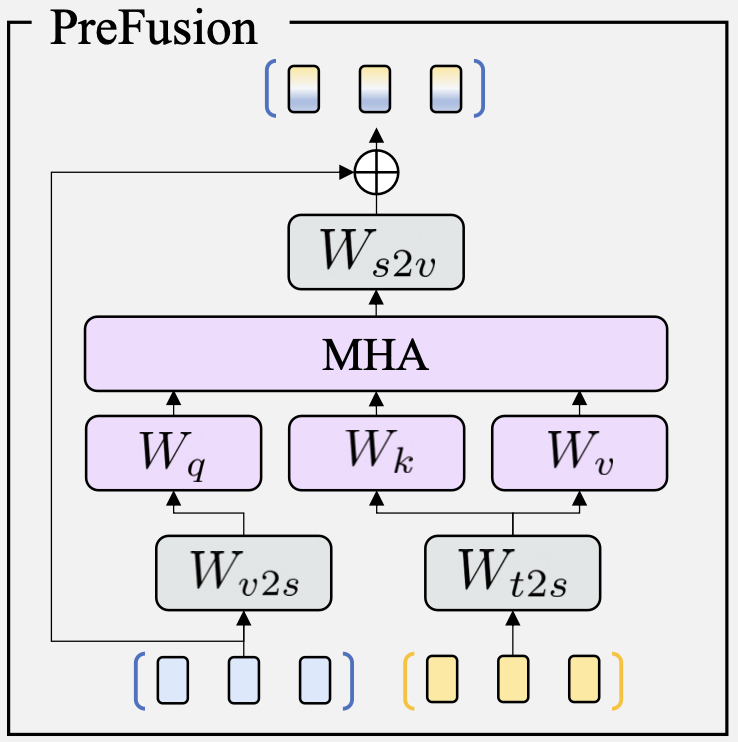
</p>

##### PostFusion Adapters

The PostFusion Adapters are attached after CLIP and take as input the final testual and visual encoder features, already projected in a shared dimension. These adapters apply cross-attention (MHA), multi-head self-attention (MHSA) and a multi-layer perceptron (MLP), each preceded by a normalization layer (LN). A single Adapter is composed of these operations, as suggested in the paper we stacked 6 of them to obtain the final image and text features with which compute the probability map.

The cross-attention is performed in the same way as in the PreFusion Adapters. Given the input features $f^{v}$ and $f^{t}$, the output of the $i_{th}$ adapter is computed as follows:

$$
{f}^{v}_{i} = \text{LN}^{v}_{1}(f^{v}_{i-1}), \quad
{f}^{t}_{i} = \text{LN}^{t}_{1}(f^{t}_{i-1})
$$
$$
{f}^{v}_{i} = \text{MHA}^{v}(q={f}^{v}_{i}, k={f}^{t}_{i}, v={f}^{t}_{i}) + {f}^{v}_{i}, \quad
{f}^{t}_{i} = \text{MHA}^{t}(q={f}^{t}_{i}, k={f}^{v}_{i}, v={f}^{v}_{i}) + {f}^{t}_{i}
$$
$$
{f}^{v}_{i} = \text{MHSA}^{v}(\text{LN}^{v}_{2}({f}^{v}_{i})) + {f}^{v}_{i}, \quad
{f}^{t}_{i} = \text{MHSA}^{t}(\text{LN}^{t}_{2}({f}^{t}_{i})) + {f}^{t}_{i}
$$
$$
{f}^{v}_{i} = \text{MLP}^{v}(\text{LN}^{v}_{3}({f}^{v}_{i})) + {f}^{v}_{i}, \quad
{f}^{t}_{i} = \text{MLP}^{t}(\text{LN}^{t}_{3}({f}^{t}_{i})) + {f}^{t}_{i}
$$


The figure below shows the PostFusion Adapters structure.

<p align="center">
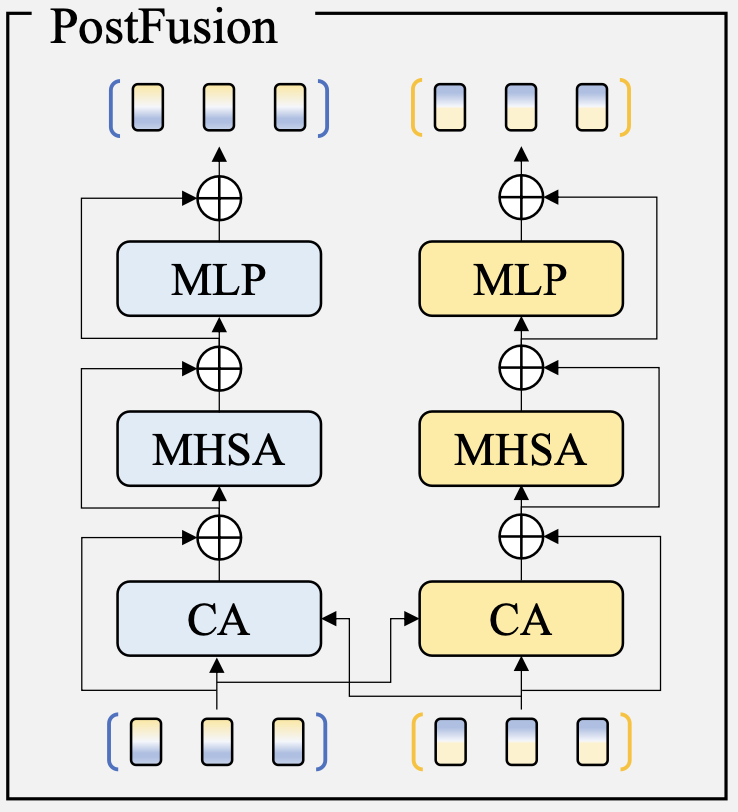
</p>

```python
import torch.nn as nn

# 768 -> hidden per visual
# 512 -> hidden per text
class BackboneAdapter(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.down_proj = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.up_proj = nn.Linear(hidden_dim, input_dim)

        # initialize down proj with Kaiming Normal, up proj with zeros
        nn.init.kaiming_normal_(self.down_proj.weight, mode='fan_in', nonlinearity='relu')
        nn.init.zeros_(self.up_proj.weight)
        self.up_proj.bias.data.fill_(0.0)

    def forward(self, x):
        x = self.down_proj(x)
        x = self.relu(x)
        x = self.up_proj(x)
        return x


class PreFusionAdapter(nn.Module):
    def __init__(self, image_input_dim, text_input_dim, shared_dim, n_head):
        super().__init__()
        self.ln_image = nn.LayerNorm(image_input_dim)
        self.ln_text = nn.LayerNorm(text_input_dim)
        self.W_v2s = nn.Linear(image_input_dim, shared_dim)
        self.W_t2s = nn.Linear(text_input_dim, shared_dim)
        self.ln_image2 = nn.LayerNorm(shared_dim)
        self.ln_text2 = nn.LayerNorm(shared_dim)
        self.CA_image = nn.MultiheadAttention(embed_dim=shared_dim, num_heads=n_head)
        self.CA_text = nn.MultiheadAttention(embed_dim=shared_dim, num_heads=n_head)
        self.ln_image3 = nn.LayerNorm(shared_dim)
        self.ln_text3 = nn.LayerNorm(shared_dim)
        self.W_s2v = nn.Linear(shared_dim, image_input_dim)
        self.W_s2t = nn.Linear(shared_dim, text_input_dim)

        # initialize projections with zeros
        nn.init.zeros_(self.W_v2s.weight)
        nn.init.zeros_(self.W_t2s.weight)
        nn.init.zeros_(self.W_s2v.weight)
        nn.init.zeros_(self.W_s2t.weight)
        self.W_v2s.bias.data.fill_(0.0)
        self.W_t2s.bias.data.fill_(0.0)
        self.W_s2v.bias.data.fill_(0.0)
        self.W_s2t.bias.data.fill_(0.0)

    def forward(self, image, text):
        # LN -> down proj -> LN -> CA (MHA) -> LN -> up proj
        image = self.ln_image(image)
        text = self.ln_text(text)
        image = self.W_v2s(image)
        text = self.W_t2s(text)
        image = self.ln_image2(image)
        text = self.ln_text2(text)
        # in CA_image the query is the image, the key and value are the text
        image, _ = self.CA_image(query=image, key=text, value=text, need_weights=False)
        text, _ = self.CA_text(query=text, key=image, value=image, need_weights=False)
        image = self.ln_image3(image)
        text = self.ln_text3(text)
        image = self.W_s2v(image)
        text = self.W_s2t(text)
        return image, text


class PostFusionAdapter(nn.Module):
    def __init__(self, shared_dim, CA_n_head, MHSA_n_head, MLP_hidden_dim):
        super().__init__()
        # cross attention without the projections at the start
        # then MHSA and MLP for each modality
        self.ln_image = nn.LayerNorm(shared_dim)
        self.ln_text = nn.LayerNorm(shared_dim)
        self.CA_image = nn.MultiheadAttention(embed_dim=shared_dim, num_heads=CA_n_head)
        self.CA_text = nn.MultiheadAttention(embed_dim=shared_dim, num_heads=CA_n_head)
        self.ln_image2 = nn.LayerNorm(shared_dim)
        self.ln_text2 = nn.LayerNorm(shared_dim)
        self.MHSA_image = nn.MultiheadAttention(embed_dim=shared_dim, num_heads=MHSA_n_head)
        self.MHSA_text = nn.MultiheadAttention(embed_dim=shared_dim, num_heads=MHSA_n_head)
        self.ln_image3 = nn.LayerNorm(shared_dim)
        self.ln_text3 = nn.LayerNorm(shared_dim)
        self.MLP_image = nn.Sequential(
            nn.Linear(shared_dim, MLP_hidden_dim),
            nn.ReLU(),
            nn.Linear(MLP_hidden_dim, shared_dim)
        )
        self.MLP_text = nn.Sequential(
            nn.Linear(shared_dim, MLP_hidden_dim),
            nn.ReLU(),
            nn.Linear(MLP_hidden_dim, shared_dim)
        )

        # initialize MLPs with zeros, also value projections in CA and MHSA with zeros
        nn.init.zeros_(self.MLP_image[0].weight)
        nn.init.zeros_(self.MLP_image[2].weight)
        nn.init.zeros_(self.MLP_text[0].weight)
        nn.init.zeros_(self.MLP_text[2].weight)
        nn.init.zeros_(self.CA_image.in_proj_weight[-512:]) # last 512 in first dimension are weights for value projection
        nn.init.zeros_(self.CA_text.in_proj_weight[-512:])
        nn.init.zeros_(self.MHSA_image.in_proj_weight[-512:])
        nn.init.zeros_(self.MHSA_text.in_proj_weight[-512:])

        self.MLP_image[0].bias.data.fill_(0.0)
        self.MLP_image[2].bias.data.fill_(0.0)
        self.MLP_text[0].bias.data.fill_(0.0)
        self.MLP_text[2].bias.data.fill_(0.0)
        nn.init.zeros_(self.CA_image.in_proj_bias[-512:]) # last 512 are biases for value projection
        nn.init.zeros_(self.CA_text.in_proj_bias[-512:])
        nn.init.zeros_(self.MHSA_image.in_proj_bias[-512:])
        nn.init.zeros_(self.MHSA_text.in_proj_bias[-512:])
    
    def forward(self, image, text):
        # LN -> CA (MHA) -> LN -> MHSA -> LN -> MLP
        image = self.ln_image(image)
        text = self.ln_text(text)
        image, _ = self.CA_image(query=image, key=text, value=text, need_weights=False)
        text, _ = self.CA_text(query=text, key=image, value=image, need_weights=False)
        image = self.ln_image2(image)
        text = self.ln_text2(text)
        image, _ = self.MHSA_image(query=image, key=image, value=image, need_weights=False)
        text, _ = self.MHSA_text(query=text, key=text, value=text, need_weights=False)
        image = self.ln_image3(image)
        text = self.ln_text3(text)
        image = self.MLP_image(image)
        text = self.MLP_text(text)
        return image, text
```

#### Probability Map

After the image and the sentence are processed by CLIP with the adapters added, the output of the Locator is a probability map containing 14x14 values. To understand how this map is produced, first let us talk about how both the image and text embeddings are shaped in the last layer of CLIP and what the tokens in each encoding represents. The image encoding has shape Bx197xD, where B is the batch size, D is the dimension of the embedding, and 197 is the number of tokens that are used for the specific version of CLIP we used. In particular, out of these 197 tokens, the first one is called CLS token and contains cumulative information coming from the whole image and is normally the output of CLIP, while the other 196 tokens, the ones we are interested in, are the tokens corresponding each to the 14x14 grid of patches the original image was divided in. The text embedding is instead of size BxLxD, where L is the lenght of the sentence and D is the dimension of the textual embedding. In this case, we are interested only in the last token of the sequence L which is the EOS token (end-of-sentence) that contains the summary of the information contained in the sentence.

Once obtained the tensors of shape 196xD and 1xD, one for each image and sentence associated, we compute the cosise similarity between each patch token of the image embedding and the single token coming from the text embedding, obtaining a vector of 196 values that we reshape as a 14x14 map. This map can be considered as a probability map for where the object, described in the sentence, is located in the image. In particular, the higher the value of a patch in the map, the higher the probability that the object is located in that patch. This map is the given as input to the Refiner.

Below, the image on the left is the input of the Locator, while on the right is the probability map produced as output.

<p align="center">
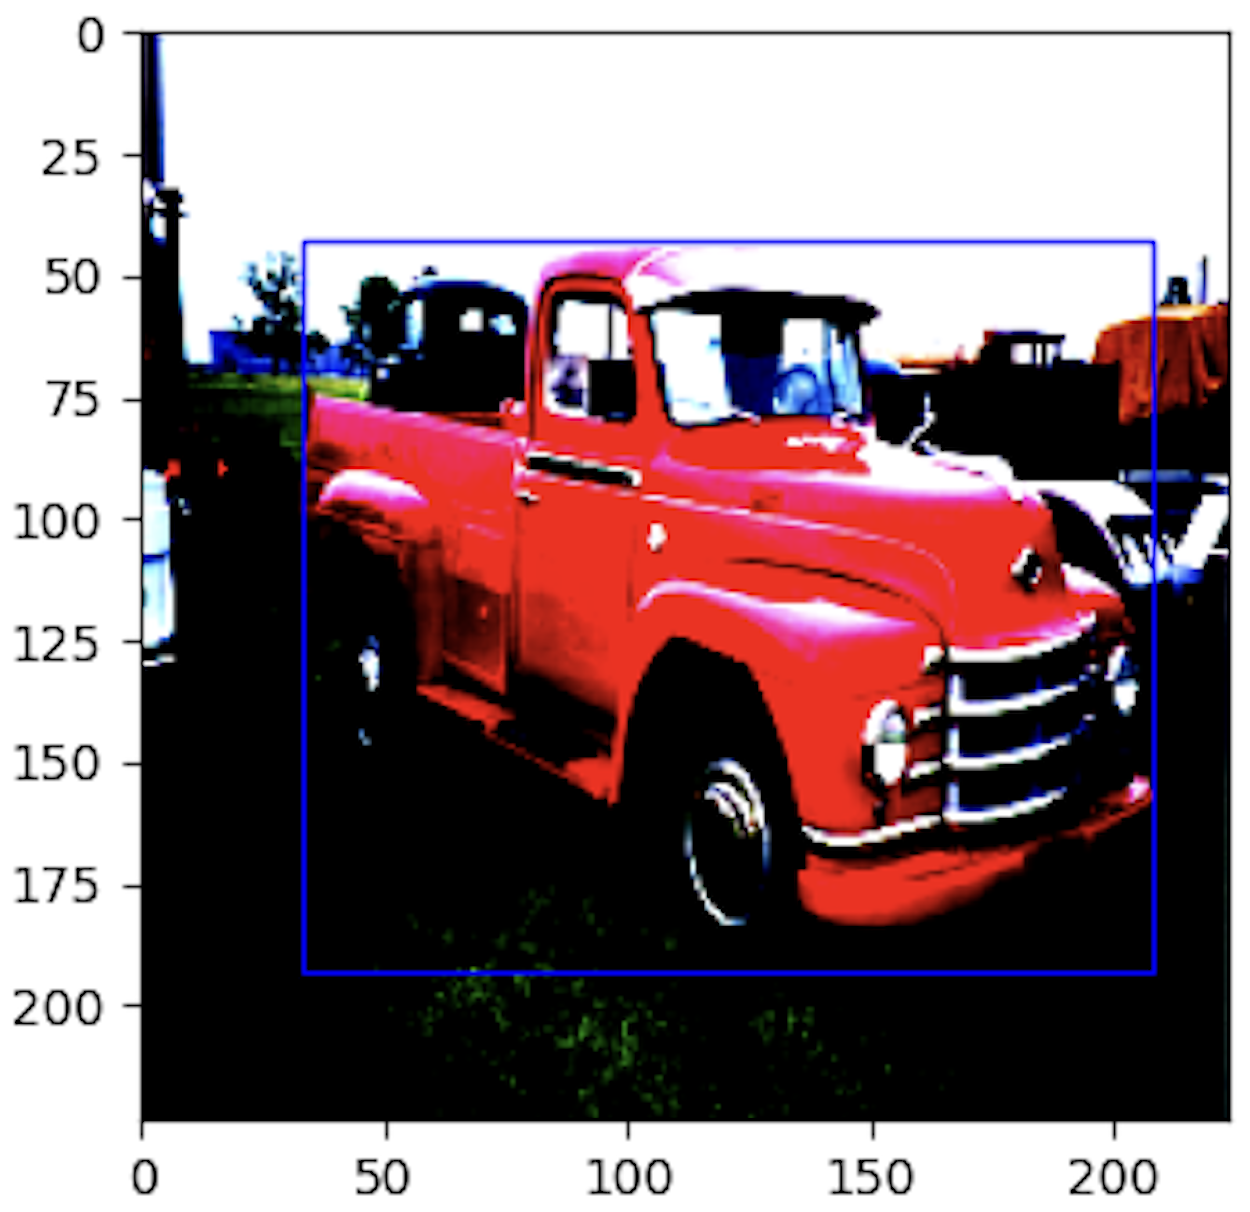
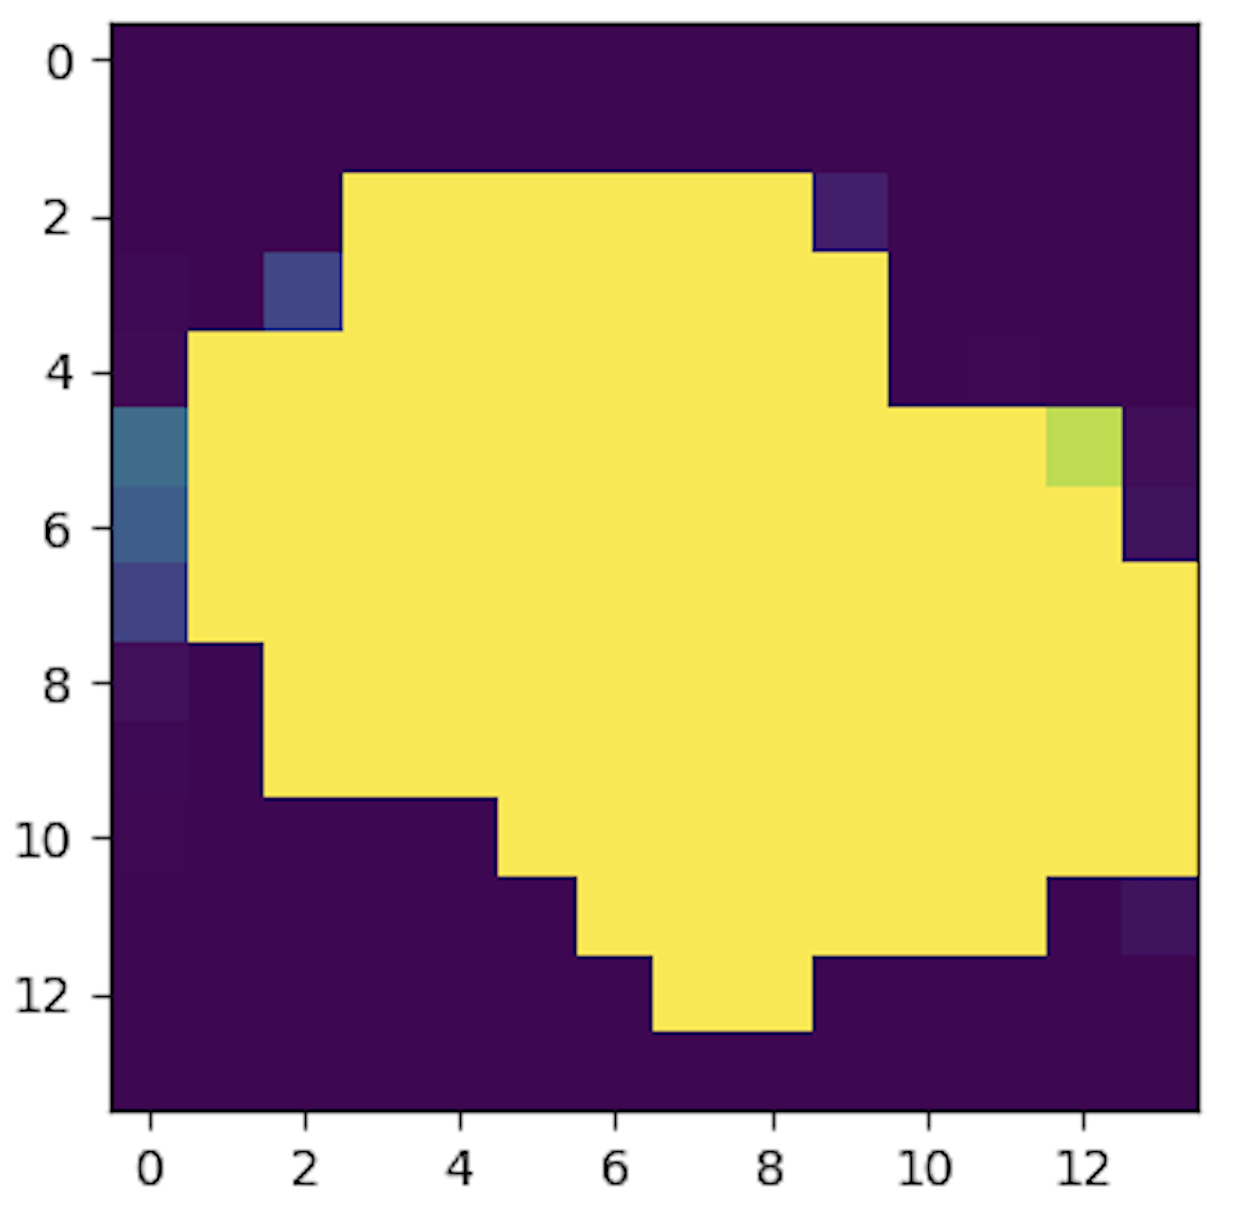
</p>

### Refiner

The Refiner has the objective to transform the low-level probability map into a segmentation map with the same size has the input.

The model consists of a series of four convolutional blocks followed by flattening, sigmoid function and reshaping to 224x224, the final output size.
\
The inputs of the model are the the low-level probability map and the visual features $f_1^v, f_2^v, f_3^v, f_4^v$, extracted by the visual encoder of the locator in the the first four layers. As previously mentioned, $f_i^v$ represents the visual encoding of a batch at level $i$ and has shape Bx196xD.
\
Each convolutional block consists of a 3x3 convolution, relu, batch normalization and a bilinear interpolation which doubles the size of the input.
In each block, the input is the output of the previous block concatenated with the visual features reshaped to 14x14.
\
In particular, the first block takes as input the probability map concatenated with $f_4^v$ reshaped to 14x14, the second block takes this output concatenated with $f_3^v$, the third one this ouput concatenated with $f_2^v$ and the last one the previous output concatenated $f_1^v$.
At each step the size is doubled, therefore the visual features are reshaped to size 14x14 and than interpolated to match the size of the map with that they has to be concatenated.
After this four blocks, the map size has increased by x16, so it's 224x224 as the original input size of the model.
\
Before to give it as output, the map is flattened, the sigmoid function applied and the size restored to 224x224.

<p align="center">
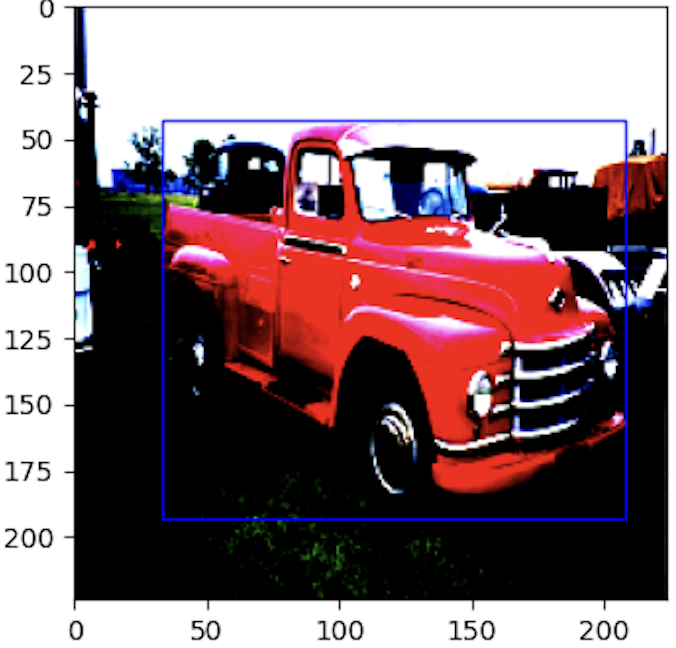
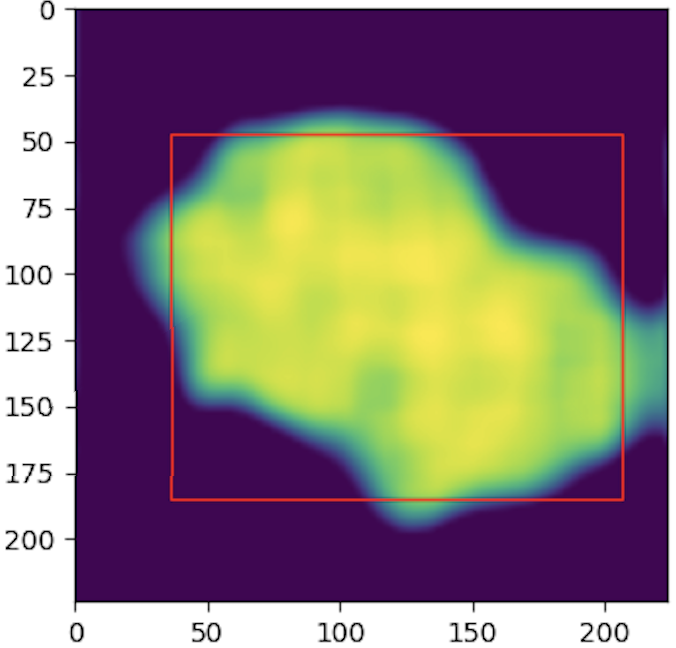
</p>

```python
import torch
import torch.nn as nn

class Refiner(nn.Module):
  """ Refiner designed to upsample from a low level probability map into a pixel probability map  """

  def __init__(self):

    super(Refiner, self).__init__()
    
    self.conv1 = nn.Conv2d(in_channels=769 , out_channels=1, kernel_size=(3, 3), padding='same')
    self.relu1 = nn.ReLU()
    self.bn1 = nn.BatchNorm2d(1)

    self.conv2 = nn.Conv2d(in_channels=769 , out_channels=1, kernel_size=(3, 3), padding='same')
    self.relu2 = nn.ReLU()
    self.bn2 = nn.BatchNorm2d(1)

    self.conv3 = nn.Conv2d(in_channels=769 , out_channels=1, kernel_size=(3, 3), padding='same')
    self.relu3 = nn.ReLU()
    self.bn3 = nn.BatchNorm2d(1)

    self.conv4 = nn.Conv2d(in_channels=769 , out_channels=1, kernel_size=(3, 3), padding='same')
    self.relu4 = nn.ReLU()
    self.bn4 = nn.BatchNorm2d(1)

    self.sigmoid = nn.Sigmoid()

  def forward(self, x, fv):
    
    """
    Args:
      x:  low level probability map (batch x 14 x 14)
      fv[0]:  image tokens encoded at layer 1   (batch x 197 x 768)
      fv[1]:  image tokens encoded at layer 2   (batch x 197 x 768)
      fv[2]:  image tokens encoded at layer 3   (batch x 197 x 768)
      fv[3]:  image tokens encoded at layer 4   (batch x 197 x 768)
    
    Returns:
      x:  pixel probability map (batch x 224 x 224)
    """

    bacth_size = fv[3].shape[0]
    n_channels = fv[3].shape[2]
    x = x.unsqueeze(1)

    #--------------------------------------------------
    # Block 1: 14 x 14 -> 28 x 28
    #--------------------------------------------------
    # Concatenate low level probability map with visual features encoded at layer 4
    fv4 = fv[3][:, 1:, :]                                # -> remove cls token
    fv4 = torch.transpose(fv4, 1, 2)                     # -> transpose to (batch x 768 x 196)
    fv4 = fv4.reshape(bacth_size, n_channels, 14, 14)    # -> reshape to (batch x 768 x 14 x 14)
    x = torch.cat([x, fv4], dim=1)                       # -> concatenate along channels
    # Upsample
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.bn1(x)
    x = nn.functional.interpolate(input=x, mode='bilinear', scale_factor=2)

    #--------------------------------------------------
    # Block 2: 28 x 28 -> 56 x 56
    #--------------------------------------------------
    # Concatenate output previous layer with visual features encoded at layer 3
    fv3 = fv[2][:, 1:, :]
    fv3 = torch.transpose(fv3, 1, 2)
    fv3 = fv3.reshape(bacth_size, n_channels, 14, 14)
    fv3 = nn.functional.interpolate(input=fv3, mode='bilinear', scale_factor=2)
    x = torch.cat([x, fv3], dim=1)
    # Upsample
    x = self.conv2(x)
    x = self.relu2(x)
    x = self.bn2(x)
    x = nn.functional.interpolate(input=x, mode='bilinear', scale_factor=2)

    #--------------------------------------------------
    # Block 3: 56 x 56 -> 112 x 112
    #--------------------------------------------------
    # Concatenate output previous layer with visual features encoded at layer 2
    fv2 = fv[1][:, 1:, :]
    fv2 = torch.transpose(fv2, 1, 2)
    fv2 = fv2.reshape(bacth_size, n_channels, 14, 14)
    fv2 = nn.functional.interpolate(input=fv2, mode='bilinear', scale_factor=4)
    x = torch.cat([x, fv2], dim=1)
    # Upsample
    x = self.conv3(x)
    x = self.relu3(x)
    x = self.bn3(x)
    x = nn.functional.interpolate(input=x, mode='bilinear', scale_factor=2)

    #--------------------------------------------------
    # Block 4: 112 x 112 -> 224 x 224
    #--------------------------------------------------
    # Concatenate output previous layer with visual features encoded at layer 1
    fv1 = fv[0][:, 1:, :]
    fv1 = torch.transpose(fv1, 1, 2)
    fv1 = fv1.reshape(bacth_size, n_channels, 14, 14)
    fv1 = nn.functional.interpolate(input=fv1, mode='bilinear', scale_factor=8)
    x = torch.cat([x, fv1], dim=1)
    # Upsample
    x = self.conv4(x)
    x = self.relu4(x)
    x = self.bn4(x)
    x = nn.functional.interpolate(input=x, mode='bilinear', scale_factor=2)

    #--------------------------------------------------
    # Sigmoid Function
    #--------------------------------------------------
    x = torch.flatten(x, start_dim=2)
    x = self.sigmoid(x)
    x = x.reshape(bacth_size, 1, 224, 224)
    x = x.squeeze(1)

    return x

```

### Training

Training for RISCLIP is performed in two separate steps, one for the Locator and one for the Refiner.

In the first step only the Locator is trained; the CLIP model is frozen with the exception of the adapters added. Images and sentences are fed into batches and the output probability maps are given to a combination of focal and DICE loss function. The ground truth in this step is lower-resolution version of the segmentation map from the training split of the dataset. If a sample image is associated with multiple describing sentences, we treat each pair of image-sentence as independent inputs. As optimizer  we used AdamW like suggestes in [5].

In the example below the image on the left is the input, the image in the center shows the ground truth segmentation map and the image on the right shows the probability map.

<p align="center">
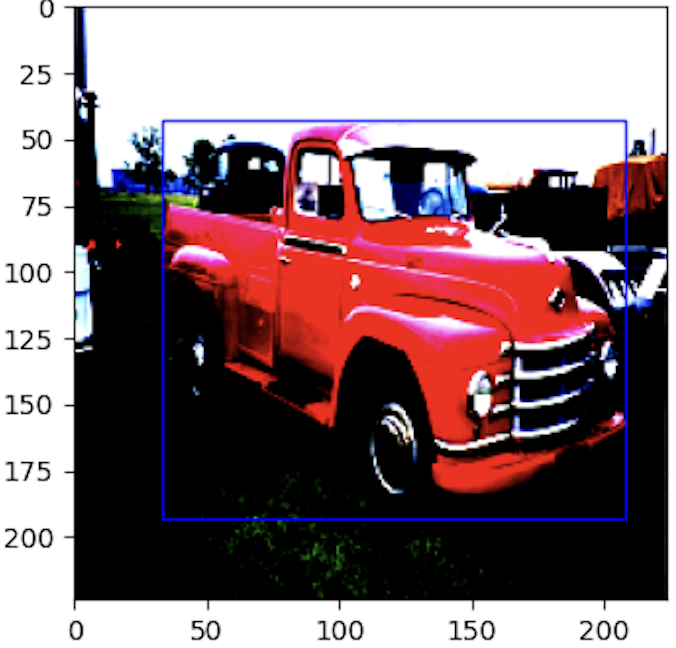
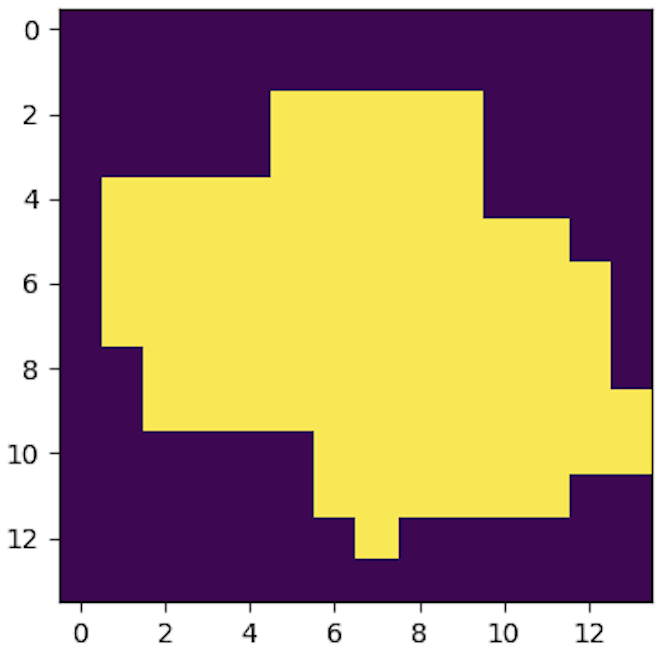
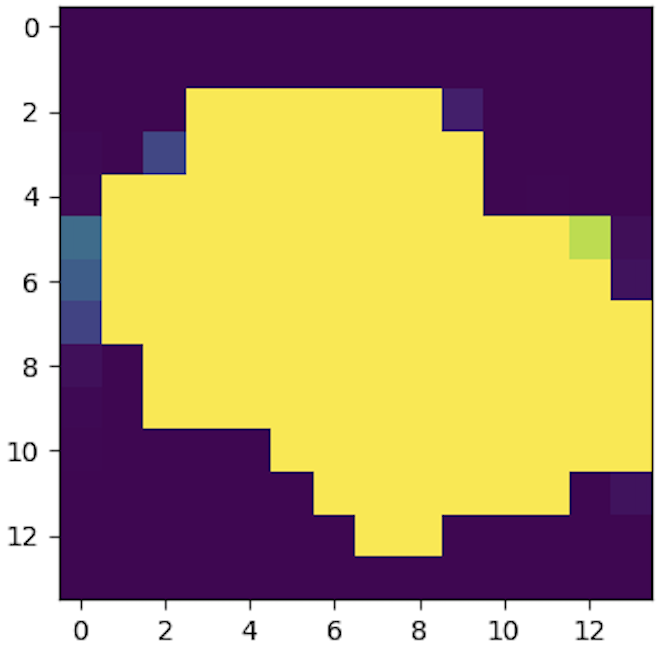
</p>

In the second step all of the CLIP backbone plus the adapters are frozen and only the Refiner is trained. The objective of the Refiner is to up-sample the probability map and to perform this task it needs not only the probability map from the Locator, but also intermediate features coming from the visual encoder of CLIP. In particular, these features come from the first 4 layers of the VisionTransformer. The loss function then receives the pixel-level probability map and the original-resolution ground-truth segmentation map.

The images below show on the left the ground truth and on the right the output probability map.

<p align="center">
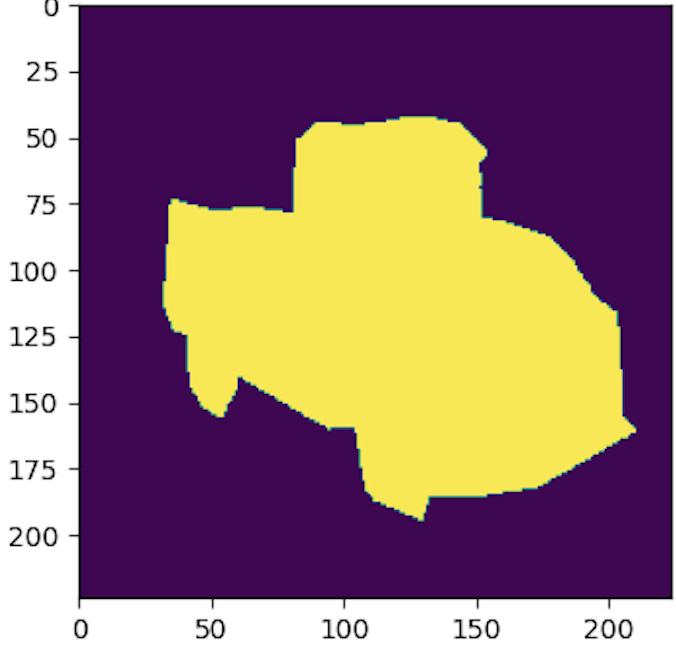
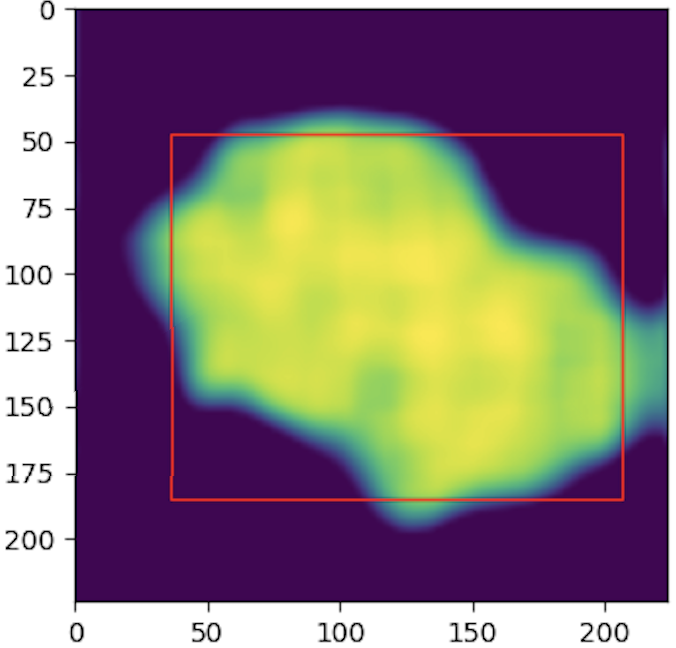
</p>

We can see below the graphs showing training and evaluation loss of the Locator training step.

<p align="center">
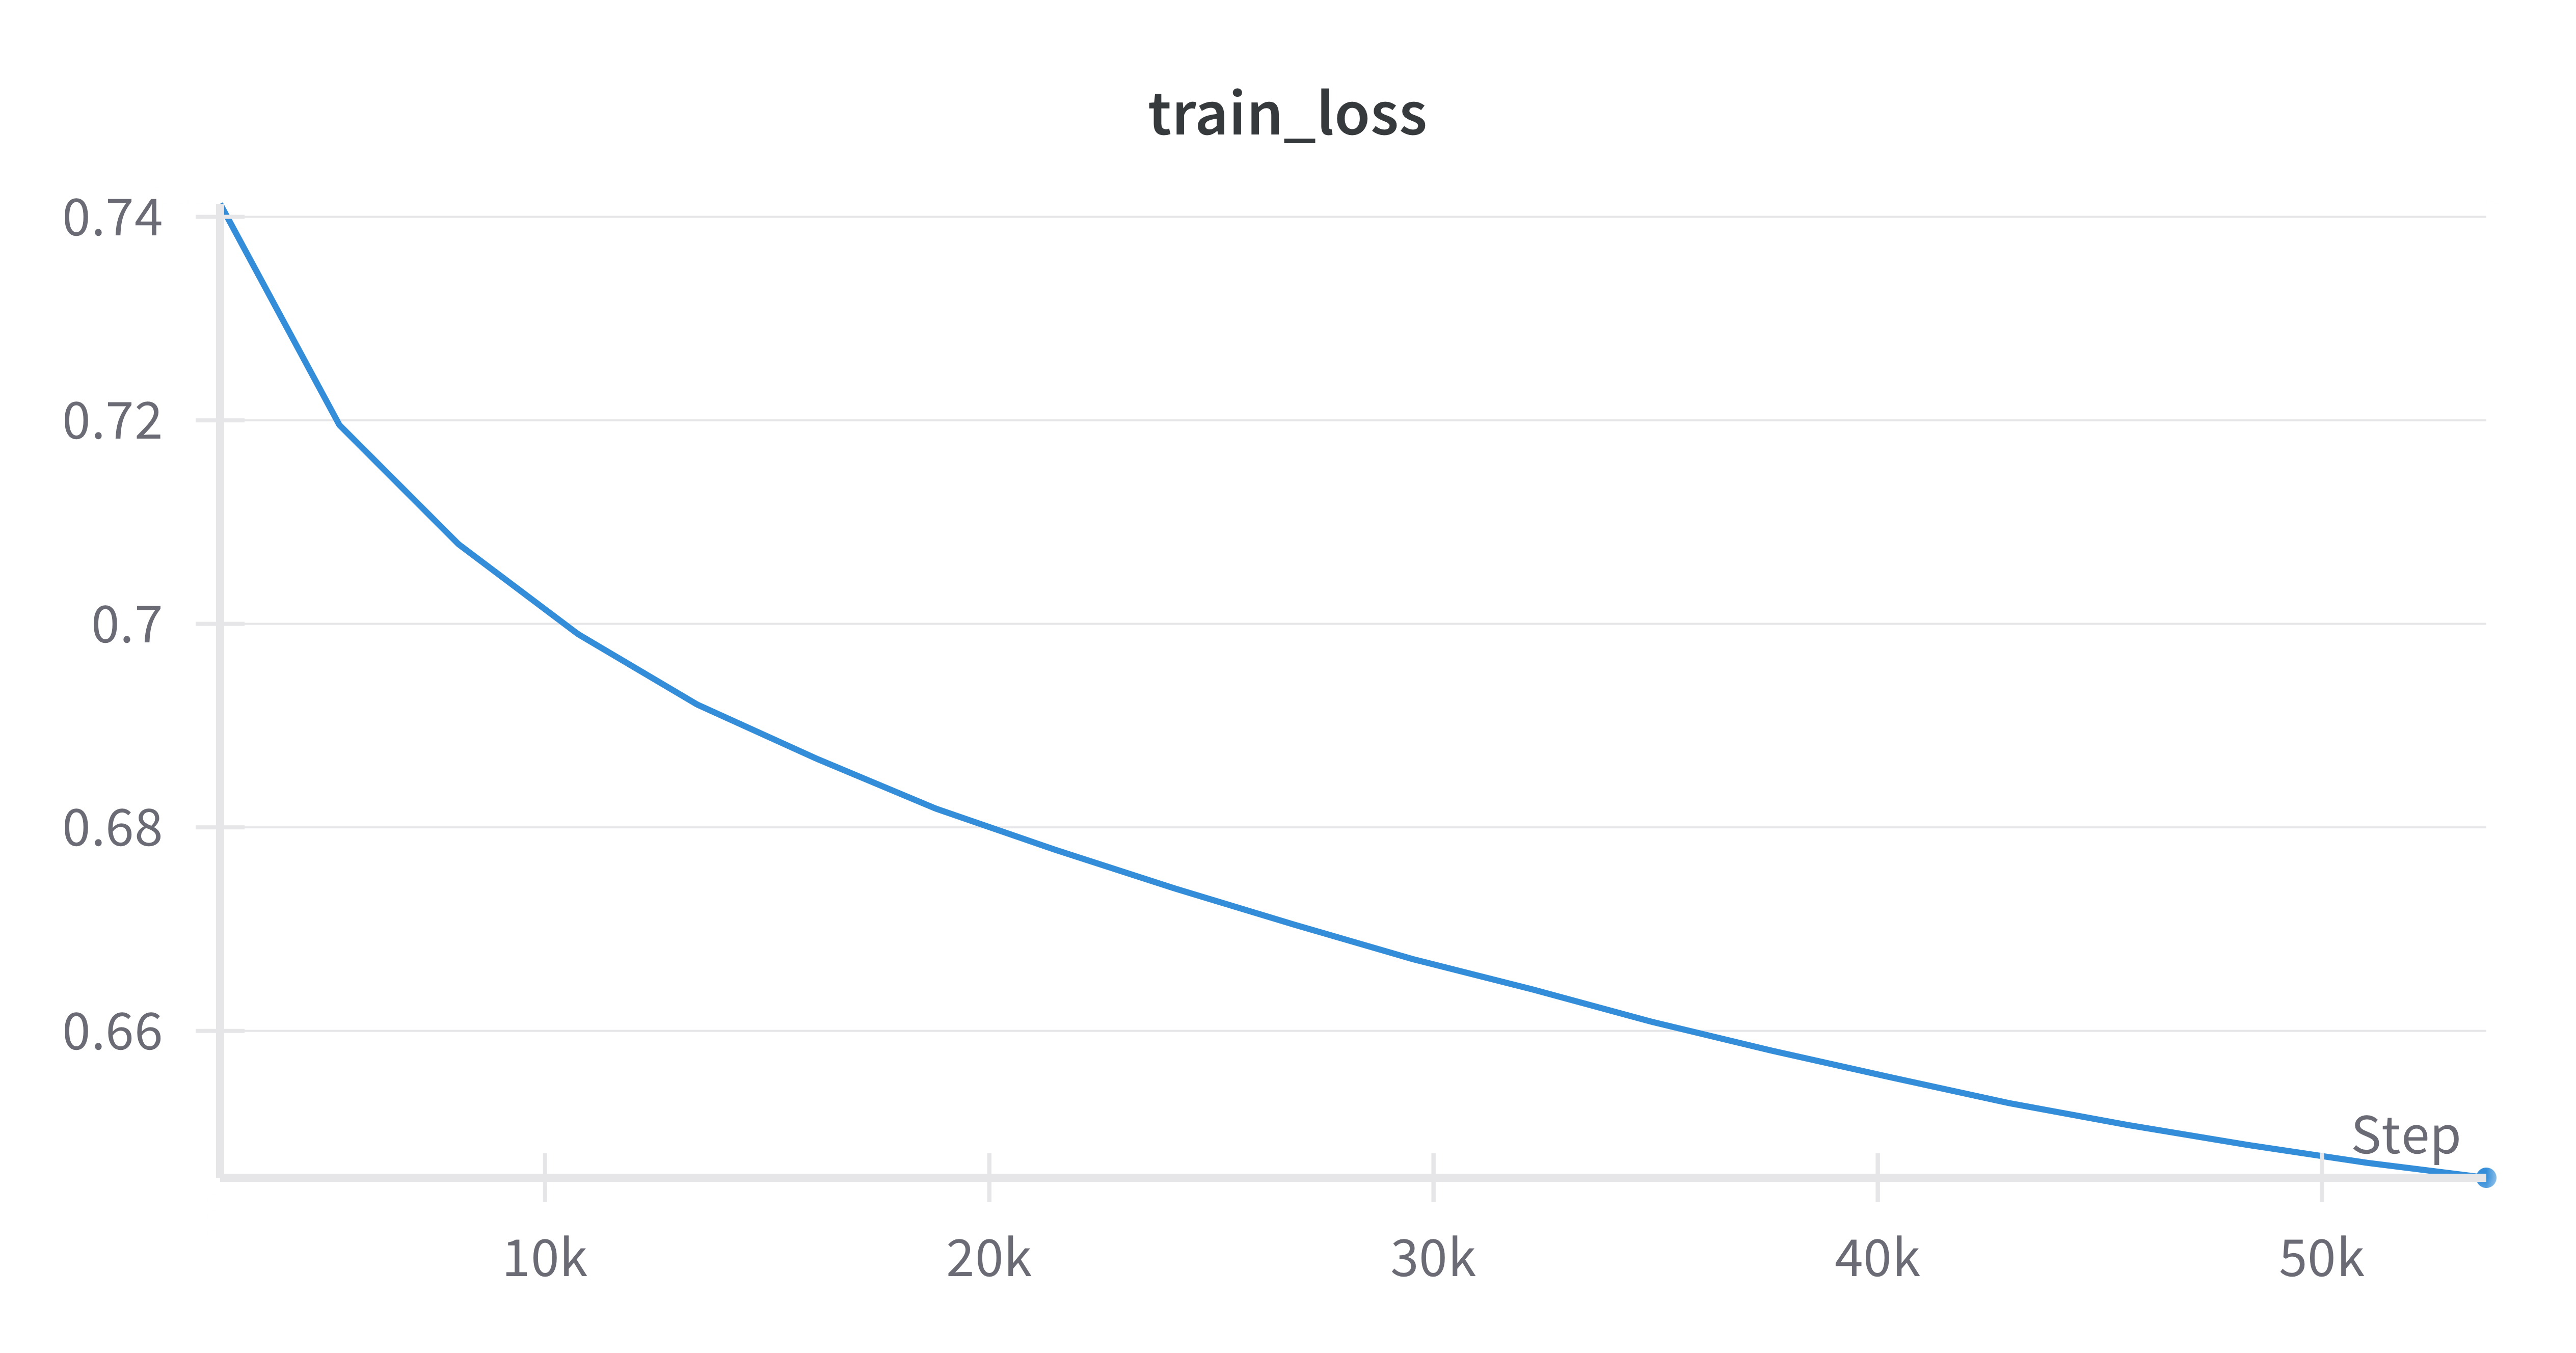
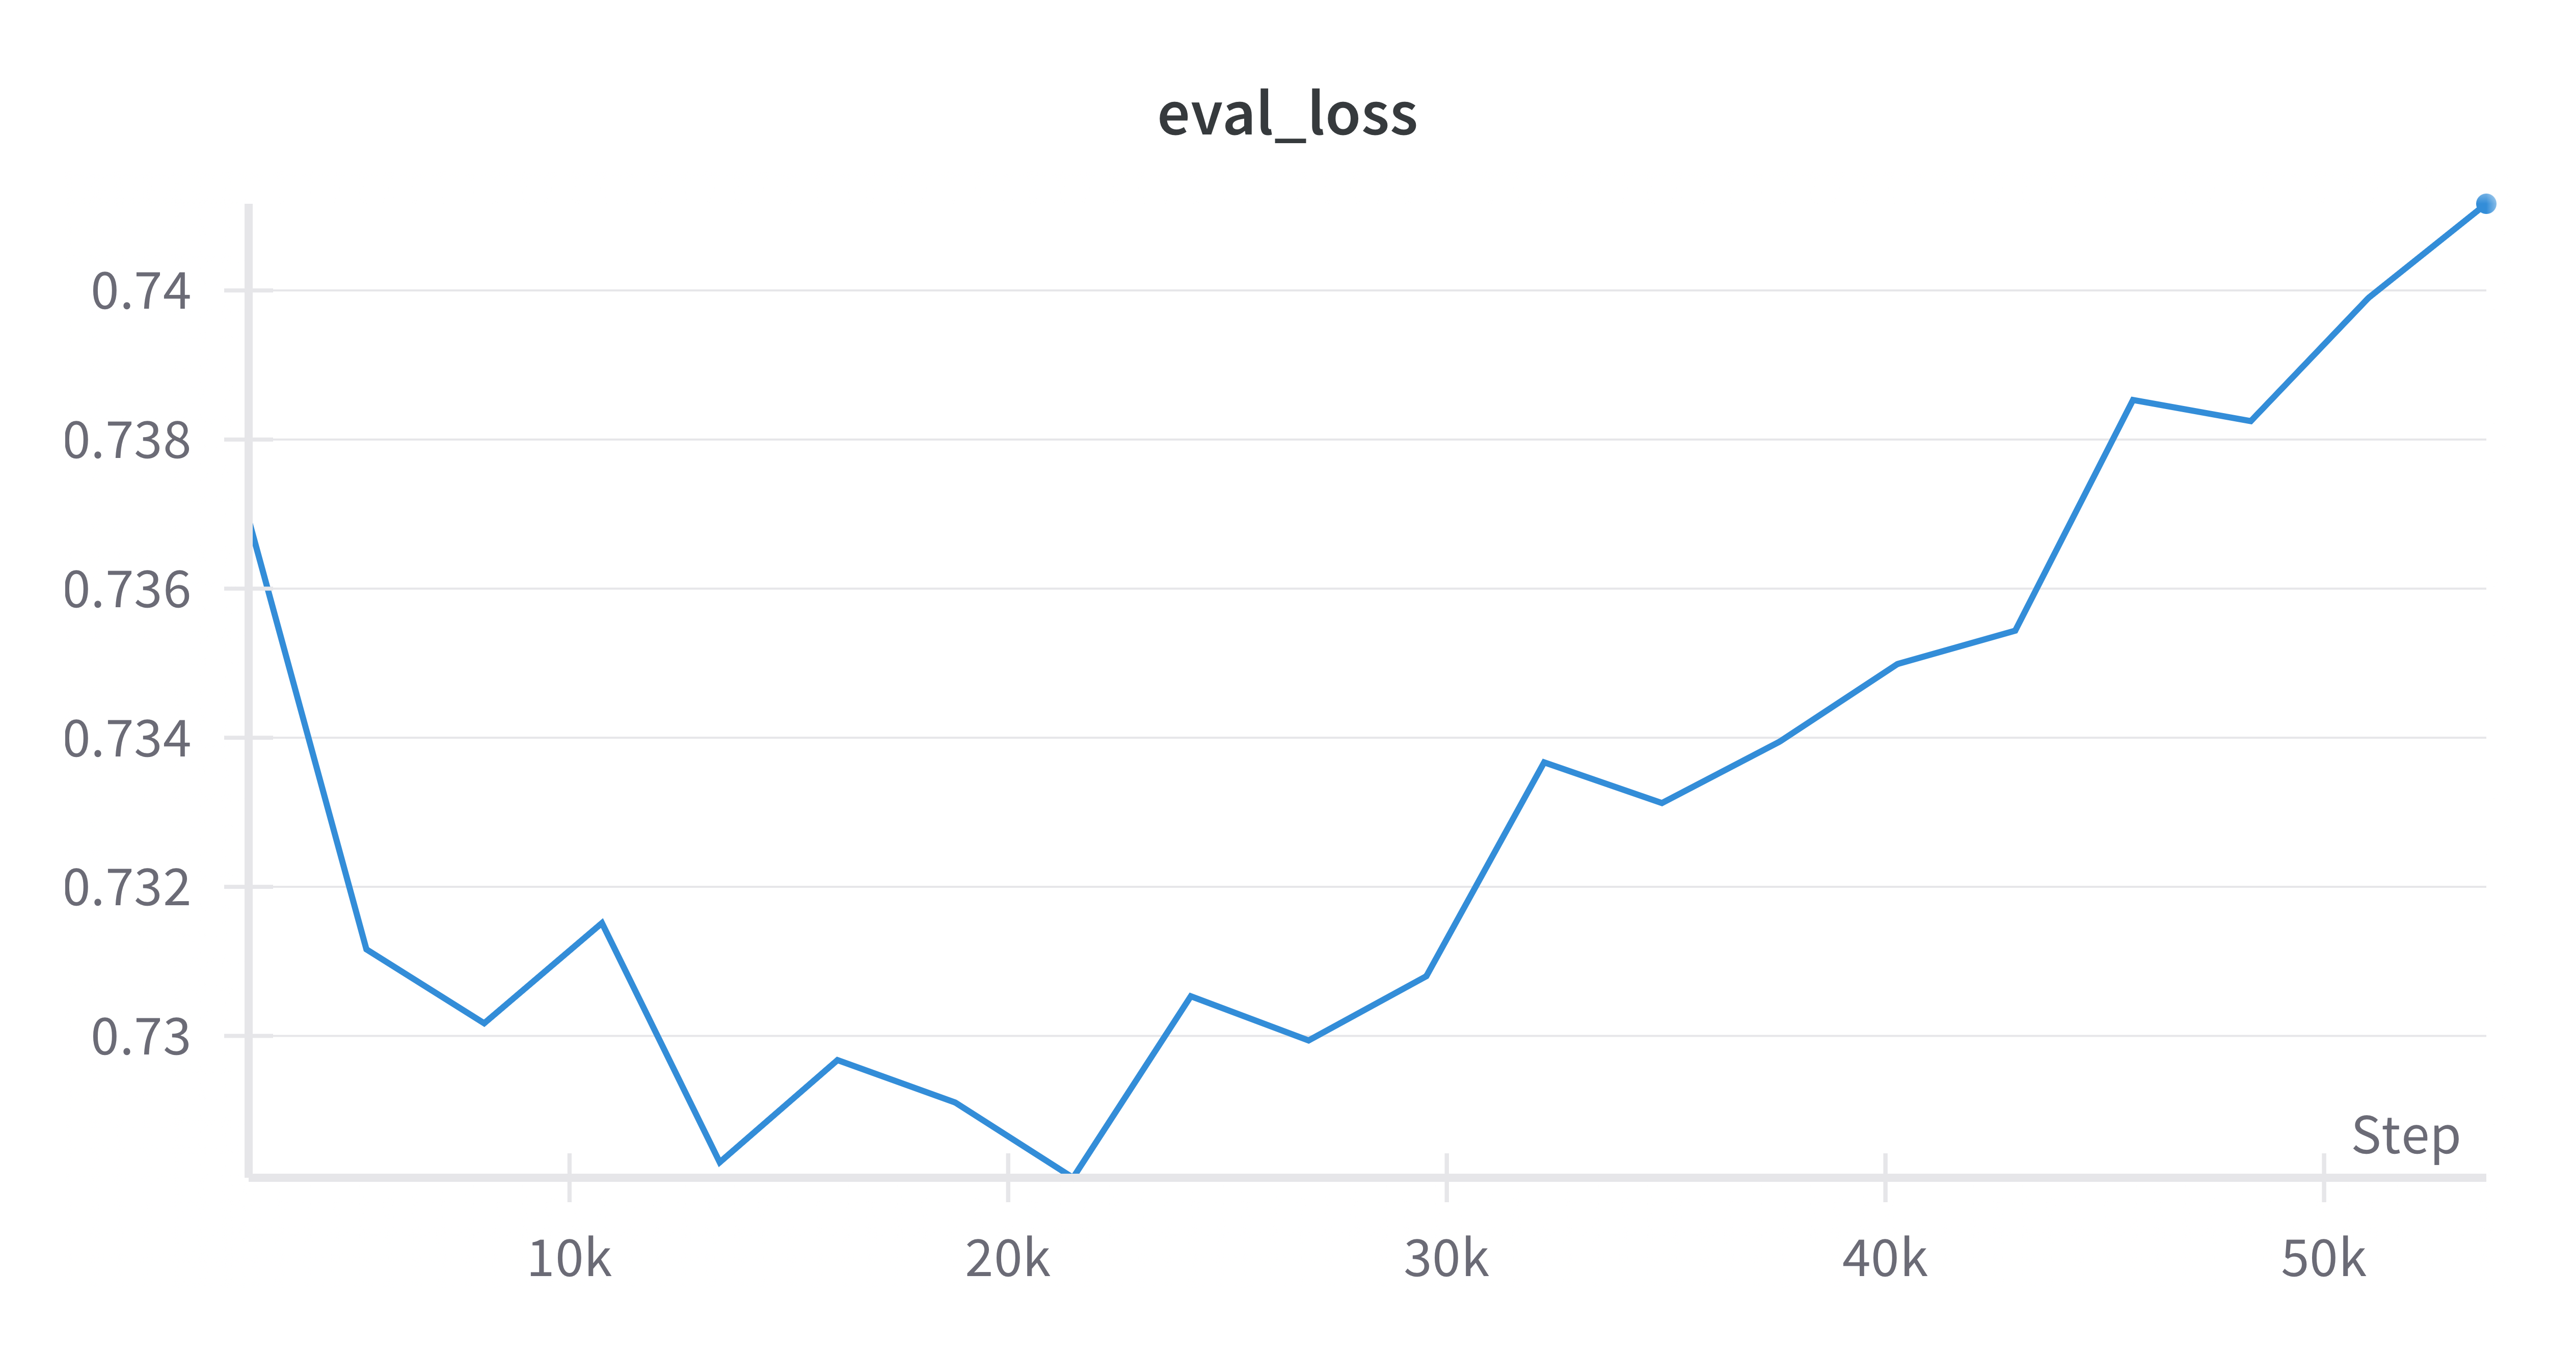
</p>

Below we can see the training and evaluation loss of the Refiner training step.

#### Loss Function

As suggested in [5], we used a combination of DICE and focal loss to guide the training. The same loss has been used for the training of Locator and Refiner, and in both cases the input is a probability map and a segmentation map with the only difference of resolution of inputs (14x14 or pixel-level). A value $\lambda$ is added to modify the contribution of each term. The loss function is defined as:

$$
\mathcal{L}(x, y) = \lambda_{focal}\mathcal{L}_{focal}(x, y) + \lambda_{dice}\mathcal{L}_{dice}(x, y)
$$

```python
import torch
import torch.nn as nn
import torch.nn.functional as F

# source: https://pytorch.org/vision/main/_modules/torchvision/ops/focal_loss.html
def focal_loss(inputs, targets, alpha, gamma, reduction="none"):
    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = inputs * targets + (1 - inputs) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss

    if reduction == "mean":
        loss = loss.mean()
    elif reduction == "sum":
        loss = loss.sum()

    return loss

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

# the final loss function is a combination of focal and dice loss, both for locator and refiner trainings
class FocalDiceLoss(nn.Module):
    def __init__(self, focal_alpha=0.65, focal_gamma=2.0, lambda_focal=1.75, lambda_dice=1.0, apply_sigmoid=False):
        super(FocalDiceLoss, self).__init__()
        self.alpha = focal_alpha
        self.gamma = focal_gamma
        self.lambda_focal = lambda_focal
        self.lambda_dice = lambda_dice
        self.apply_sigmoid = apply_sigmoid

    def forward(self, inputs, targets):
        targets = targets.to(inputs.dtype)

        if self.apply_sigmoid:
            inputs = torch.sigmoid(inputs)
        
        f_loss = focal_loss(inputs, targets, alpha=self.alpha, gamma=self.gamma, reduction="mean")
        d_loss = DiceLoss().forward(inputs, targets)
        loss = self.lambda_focal * f_loss + self.lambda_dice * d_loss # values used --> (1.75 * focal) + (1 * dice)

        return loss
```

### Evaluation

#### Demonstration

#### Results (both qualitative and quantitative)

- probabilmente overfitta o chi lo sa
- in generale trova gli oggetti ma fatica a differenziare con le descrizioni specifiche
- facciamo girare qualche esempio e vediamo di discutere

come migliorare:
- utilizzare versione di clip migliore vit-l
- magari qualcosa di regularization o diminuire numero di layer/adapters per vedere se diminuendo capacità migliora

## Conclusion

## References

1. Redmon, Joseph, Santosh Divvala, Ross Girshick, and Ali Farhadi. "You only look once: Unified, real-time object detection." In Proceedings of the IEEE conference on computer vision and pattern recognition, pp. 779-788. 2016.

2. Radford, Alec, Jong Wook Kim, Chris Hallacy, Aditya Ramesh, Gabriel Goh, Sandhini Agarwal, Girish Sastry et al. "Learning transferable visual models from natural language supervision." In International conference on machine learning, pp. 8748-8763. PMLR, 2021.

3. Li, Junnan, Dongxu Li, Caiming Xiong, and Steven Hoi. "Blip: Bootstrapping language-image pre-training for unified vision-language understanding and generation." In International Conference on Machine Learning, pp. 12888-12900. PMLR, 2022.

4. Kirillov, Alexander, Eric Mintun, Nikhila Ravi, Hanzi Mao, Chloe Rolland, Laura Gustafson, Tete Xiao et al. "Segment anything." arXiv preprint arXiv:2304.02643 (2023).

5. Kim, Seoyeon, Minguk Kang, and Jaesik Park. "RISCLIP: Referring Image Segmentation Framework using CLIP." arXiv preprint arXiv:2306.08498 (2023).

6. Vaswani, Ashish, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Łukasz Kaiser, and Illia Polosukhin. "Attention is all you need." Advances in neural information processing systems 30 (2017).


Per aggiungere una citazione andare su https://scholar.google.com , cercare il nome del paper, una volta trovato premere sul pulsantino "Cite" e copiare la citazione nello stile Chicago. Si prega di non cambiare i numeri già messi

## Appendix

Qua pensavo di metterci tutto quello che non mettiamo direttamente nel report, quindi codice che abbiamo scritto/modificato che però non è il punto centrale. Ci possiamo mettere anche risultati secondari.

### Hyperparameters / other values used in training and loss function

Hyperparameters used in RISCLIP model in locator, refiner, adapters, training of both

TODO

| CLIP model | | 
|-|:-:|
| Model version | ViT-B/16 |
| Image encoder embedding dimension | 768 |
| Text encoder embedding dimension | 512 |
| Final embedding dimension | 512 |

| Backbone Adapters | |
|-|:-:|
| Non linear activation | ReLU |
| Hidden dimension (image) | 384 |
| Hidden dimension (text) | 512 |
| Number of adapters (both) | 12 |

| PreFusion Adapters | |
|-|:-:|
| Shared dimension | 512 |
| Cross-Attention n. heads | 8 |
| Number of adapters | 6 |

| PostFusion Adapters | |
|-|:-:|
| Cross-Attention n. heads | 8 |
| MHSA n. heads | 8 |
| MLP hidden dimension | 256 |
| Activation function | 6 |
| Number of adapters | 6 |

| Refiner | |
|-|:-:|
| input map size | 14x14 |
| input $f_i^v$ size | 196x768 |
| output size | 224x224 |
| kernel | 3x3 |
| padding | 'same' |
| activation function | Relu |
| interpolation | bilinear |

| Training Locator | |
|-|:-:|
| Batch size | 30 |
| Number of epochs | 20 |
| Optimizer | AdamW |
| Learning rate | 4,6875e-5 |
| Weight decay AdamW | 5e-3 |
| Betas AdamW | 0.9, 0.999 |
| Eps AdamW | 1e-8 |
| Scheduler | PolynomialLR |
| $\alpha_{focal}$ | 0.65 |
| $\gamma_{focal}$ | 2.0 |
| $\lambda_{focal}$ | 1.75 |
| $\lambda_{dice}$ | 1.0 |

| Training Refiner | |
|-|:-:|
| Batch size | 16 |
| Number of epochs | 1 |
| Learning rate | 5e-5 |
| Optimizer | Adamw |
| Weight decay AdamW | 5e-3 |
| Betas AdamW | 0.9, 0.999 |
| Eps AdamW | 1e-8 |
| Scheduler | PolynomialLR |
| $\alpha_{focal}$ | 0.65 |
| $\gamma_{focal}$ | 2.0 |
| $\lambda_{focal}$ | 1.75 |
| $\lambda_{dice}$ | 1.0 |